### Formal Analysis Walkthrough Notebook

The purpose of this notebook is to walk through the formal analysis in the work: "An Interpretable Machine Learning Framework for Modelling Macromolecular Interaction Mechanisms with Nuclear Magnetic Resonance."

This notebook may be cloned and similarly applied to conduct formal analysis of other DISCO NMR interaction screening datasets.

Import and Install Required Python Packages.

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn

# image conversion
import cairosvg
from io import BytesIO
from dtreeviz.trees import *
from PIL import Image

# ML
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn import tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from collections import Counter

# legend helpers for biplots
import matplotlib.patches as mpatches
import matplotlib.lines as mlines


Import custom feature generation functions:

In [95]:
from utils.feature_generation import *

Custom colors called in decision tree visualizations:

In [96]:
custom_colors = ['#377eb8', '#984ea3', '#ff7f00', '#e41a1c', '#f781bf',
                 '#ffff33', '#4daf4a', '#a65628', '#999999']

# set decision tree clf color palette 
colors_for_2_classes = [None,  # 0 classes
                        None,  # 1 class
                        [custom_colors[0], custom_colors[2]]] # 2 classes


In [97]:
!python --version

Python 3.7.16


In [98]:
print(sklearn.__version__)

1.0.2


### 1.0 Read Data 


In [99]:
data = pd.read_excel("../data/raw/proton_binding_dataset.xlsx", sheet_name= 'Sheet1').drop(columns = "Unnamed: 0")

Binarize binding AF0 into classification label:

In [100]:
data['bind'] = data['AFo'].abs().apply(lambda x: 1 if x!=0 else 0)

In [101]:
df = data.copy()

### 2.0 Generate Machine Learning Features

Applies DISCO feature generation utility fuctions to:

* Extract molecular weight from polymer name
* Generate cohort fingerprint indicating the chemical shift intervals (0.1ppm step size) of protons that are part of the same parent polymer for each sample proton.

In [102]:
# adds columns to df that bin ppms 
df = generate_ppm_bins(df)
df = generate_categorical(df, 'polymer_name')

# add mW
df['molecular_weight'] = df['polymer_name'].apply(lambda x: extract_molecular_weight(x))

# add cohort chemical shift fingerprint from ppm vector and polymer name strings
zipcode_df, ppm_bin_conversion_dict, polymer_name_conversion_dict = generate_polymer_zip_codes(df, kind='cohort')
interim_modelling_data = df.copy().drop(columns = ['amp_factor', 'AFo', 'SSE', 'alpha', 'beta', 'sample_size', 'proton_peak_index'])
interim_modelling_data = append_multilabel_zipcodes(interim_modelling_data, ppm_bin_conversion_dict)

# remove empty cohort columns, keep only cols w some 1's
interim_modelling_data = interim_modelling_data.loc[:, (interim_modelling_data != 0).any(axis=0)]
modelling_df = interim_modelling_data.copy().drop(columns=["polymer_zip_code", "concentration",'ppm_bin', "polymer_name", "ppm_bin_codes", "polymer_name_codes"])


Save an understandable "lookup" table for downstream interpretation:

In [103]:
interpretable_df = interim_modelling_data.copy()

# grab values for downstream lookup
polymer_names = interpretable_df['polymer_name']
unique_polymers = polymer_names.unique()
poly_ix_list = [interpretable_df.loc[interpretable_df['polymer_name']
                                     == polymer].index for polymer in unique_polymers]
poly_lookup_dict = dict(zip(unique_polymers, poly_ix_list))

display(interpretable_df.head())


,polymer_name,concentration,ppm_bin,corr_%_attenuation0.25,corr_%_attenuation0.5,corr_%_attenuation0.75,corr_%_attenuation1.0,corr_%_attenuation1.25,corr_%_attenuation1.5,corr_%_attenuation1.75,...,"(3.7, 3.8]","(3.8, 3.9]","(3.9, 4.0]","(4.0, 4.1]","(4.2, 4.3]","(4.3, 4.4]","(4.4, 4.5]","(4.5, 4.6]","(5.1, 5.2]","(5.2, 5.3]"
0,Dextran_150k_20uM,20,"(5.2, 5.3]",0.015418,0.002828,-0.004538,0.002257,-0.009912,-0.016120,0.003645,...,1,1,0,1,1,0,0,0,1,0
1,Dextran_150k_20uM,20,"(5.1, 5.2]",0.095602,-0.013616,-0.048097,0.029934,-0.162398,-0.090247,-0.036158,...,1,1,0,1,1,0,0,0,0,1
2,HPC_370k_20uM,20,"(4.5, 4.6]",0.065708,0.024242,0.033384,0.079823,0.094301,0.080398,0.087829,...,1,0,0,1,0,0,0,0,0,0
3,HPC_80k_20uM,20,"(4.5, 4.6]",-0.481986,-0.273215,-0.018844,-0.711022,-0.137549,-0.370218,-0.393501,...,1,0,0,1,0,0,0,0,0,0
4,CMC_131k_20uM,20,"(4.5, 4.6]",-0.001168,-0.032334,-0.026764,-0.026776,-0.042765,-0.047105,-0.053642,...,1,0,1,1,1,1,0,0,0,0


Take absolute DISCO Effect Values, drop DISCO effect standard deviation data.

In [104]:
# take absolute disco effect
modelling_df = modelling_df.abs()

# drop std dev of discoeffect
modelling_df = modelling_df.drop(columns = ['corr_%_attenuation0.25_std',
        'corr_%_attenuation0.5_std', 'corr_%_attenuation0.75_std',
        'corr_%_attenuation1.0_std', 'corr_%_attenuation1.25_std',
        'corr_%_attenuation1.5_std', 'corr_%_attenuation1.75_std'])

View raw modelling features:

In [105]:
print(modelling_df.columns)

Index(['corr_%_attenuation0.25',  'corr_%_attenuation0.5',
       'corr_%_attenuation0.75',  'corr_%_attenuation1.0',
       'corr_%_attenuation1.25',  'corr_%_attenuation1.5',
       'corr_%_attenuation1.75',                   'bind',
                          'ppm',       'molecular_weight',
                     (0.9, 1.0],               (1.0, 1.1],
                     (1.1, 1.2],               (1.2, 1.3],
                     (1.4, 1.5],               (1.5, 1.6],
                     (1.7, 1.8],               (1.8, 1.9],
                     (2.0, 2.1],               (2.1, 2.2],
                     (2.2, 2.3],               (2.3, 2.4],
                     (2.4, 2.5],               (2.5, 2.6],
                     (2.8, 2.9],               (3.0, 3.1],
                     (3.1, 3.2],               (3.2, 3.3],
                     (3.3, 3.4],               (3.4, 3.5],
                     (3.5, 3.6],               (3.6, 3.7],
                     (3.7, 3.8],               (3.8, 3.9

Set up features and labels for modelling:

In [106]:
X = modelling_df.copy()
y = modelling_df['bind']
X = X.drop(columns = ['bind'])

In [107]:
print(X.shape, y.shape)

(99, 41) (99,)


In [108]:
display(X.head())

,corr_%_attenuation0.25,corr_%_attenuation0.5,corr_%_attenuation0.75,corr_%_attenuation1.0,corr_%_attenuation1.25,corr_%_attenuation1.5,corr_%_attenuation1.75,ppm,molecular_weight,"(0.9, 1.0]",...,"(3.7, 3.8]","(3.8, 3.9]","(3.9, 4.0]","(4.0, 4.1]","(4.2, 4.3]","(4.3, 4.4]","(4.4, 4.5]","(4.5, 4.6]","(5.1, 5.2]","(5.2, 5.3]"
0,0.015418,0.002828,0.004538,0.002257,0.009912,0.016120,0.003645,5.30,150,0,...,1,1,0,1,1,0,0,0,1,0
1,0.095602,0.013616,0.048097,0.029934,0.162398,0.090247,0.036158,5.20,150,0,...,1,1,0,1,1,0,0,0,0,1
2,0.065708,0.024242,0.033384,0.079823,0.094301,0.080398,0.087829,4.58,370,0,...,1,0,0,1,0,0,0,0,0,0
3,0.481986,0.273215,0.018844,0.711022,0.137549,0.370218,0.393501,4.58,80,0,...,1,0,0,1,0,0,0,0,0,0
4,0.001168,0.032334,0.026764,0.026776,0.042765,0.047105,0.053642,4.58,131,0,...,1,0,1,1,1,1,0,0,0,0


### 3.0 Principal Component Analyis Plots

In [109]:
from sklearn.compose import ColumnTransformer

In [110]:
discoeffonly_transformer = Pipeline([('scaler', StandardScaler()),
                                     ('pca', PCA(n_components=1)),
                                     ])
discoeffect_features = [0, 1, 2, 3, 4, 5, 6]

property_transformer = Pipeline([('filler', 'passthrough')])
property_features = np.arange(7, X.shape[1])

In [111]:
X.columns = X.columns.astype(str)

In [112]:
# CDE Computation
preprocess_pipe = ColumnTransformer(
    transformers=[
        ('discoeffonly', discoeffonly_transformer, discoeffect_features),
        ('property_transforms', property_transformer, property_features)])

# To generate figures
explore_pipe = Pipeline([
    ('preprocess', preprocess_pipe),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components='mle'))])


In [113]:
# Used to generate figures
transformed_X = explore_pipe.fit_transform(X)
print(transformed_X.shape)
expvar_ratio = explore_pipe.named_steps['pca'].explained_variance_ratio_
cumexp_var = expvar_ratio.cumsum()
factor_loadings = explore_pipe.named_steps['pca'].components_

(99, 31)


### SI Figure: Global PCA Scree Plot

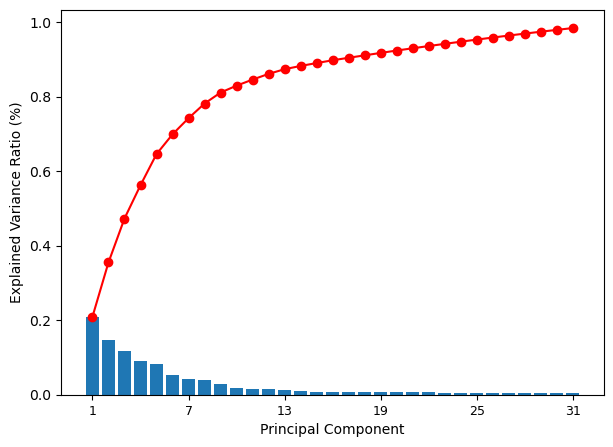

In [114]:
fig, ax = plt.subplots(figsize=(7, 5))
plt.bar(x=range(len(expvar_ratio)), height=expvar_ratio)
plt.plot(cumexp_var, c='r')
plt.scatter(x=range(len(cumexp_var)), y=cumexp_var, c='r')
plt.xticks(ticks=np.linspace(0, 30, 6),
           labels=(np.linspace(0, 30, 6)+1).astype(int), fontsize=9)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio (%)")

# save as png, svg
plt.savefig("../figures/supplementary/scree.png", dpi=150)
plt.savefig("../figures/supplementary/scree.svg", dpi=150)
plt.show()


In [115]:
print("Best number of retained components selected by Minka's MLE is:",len(expvar_ratio))
n_components = len(expvar_ratio)
pc_ids = range(1,n_components+1)

Best number of retained components selected by Minka's MLE is: 31


In [116]:
print("Retained explained variance:", cumexp_var[n_components-1])

Retained explained variance: 0.9839456058166979


In [117]:
# retain factor names for downstream plots
factornames = ['cumulative_disco_effect'] + list(X.columns[property_features])
print(len(factornames))

35


### SI Figure: Global Principal Component Factor Loadings

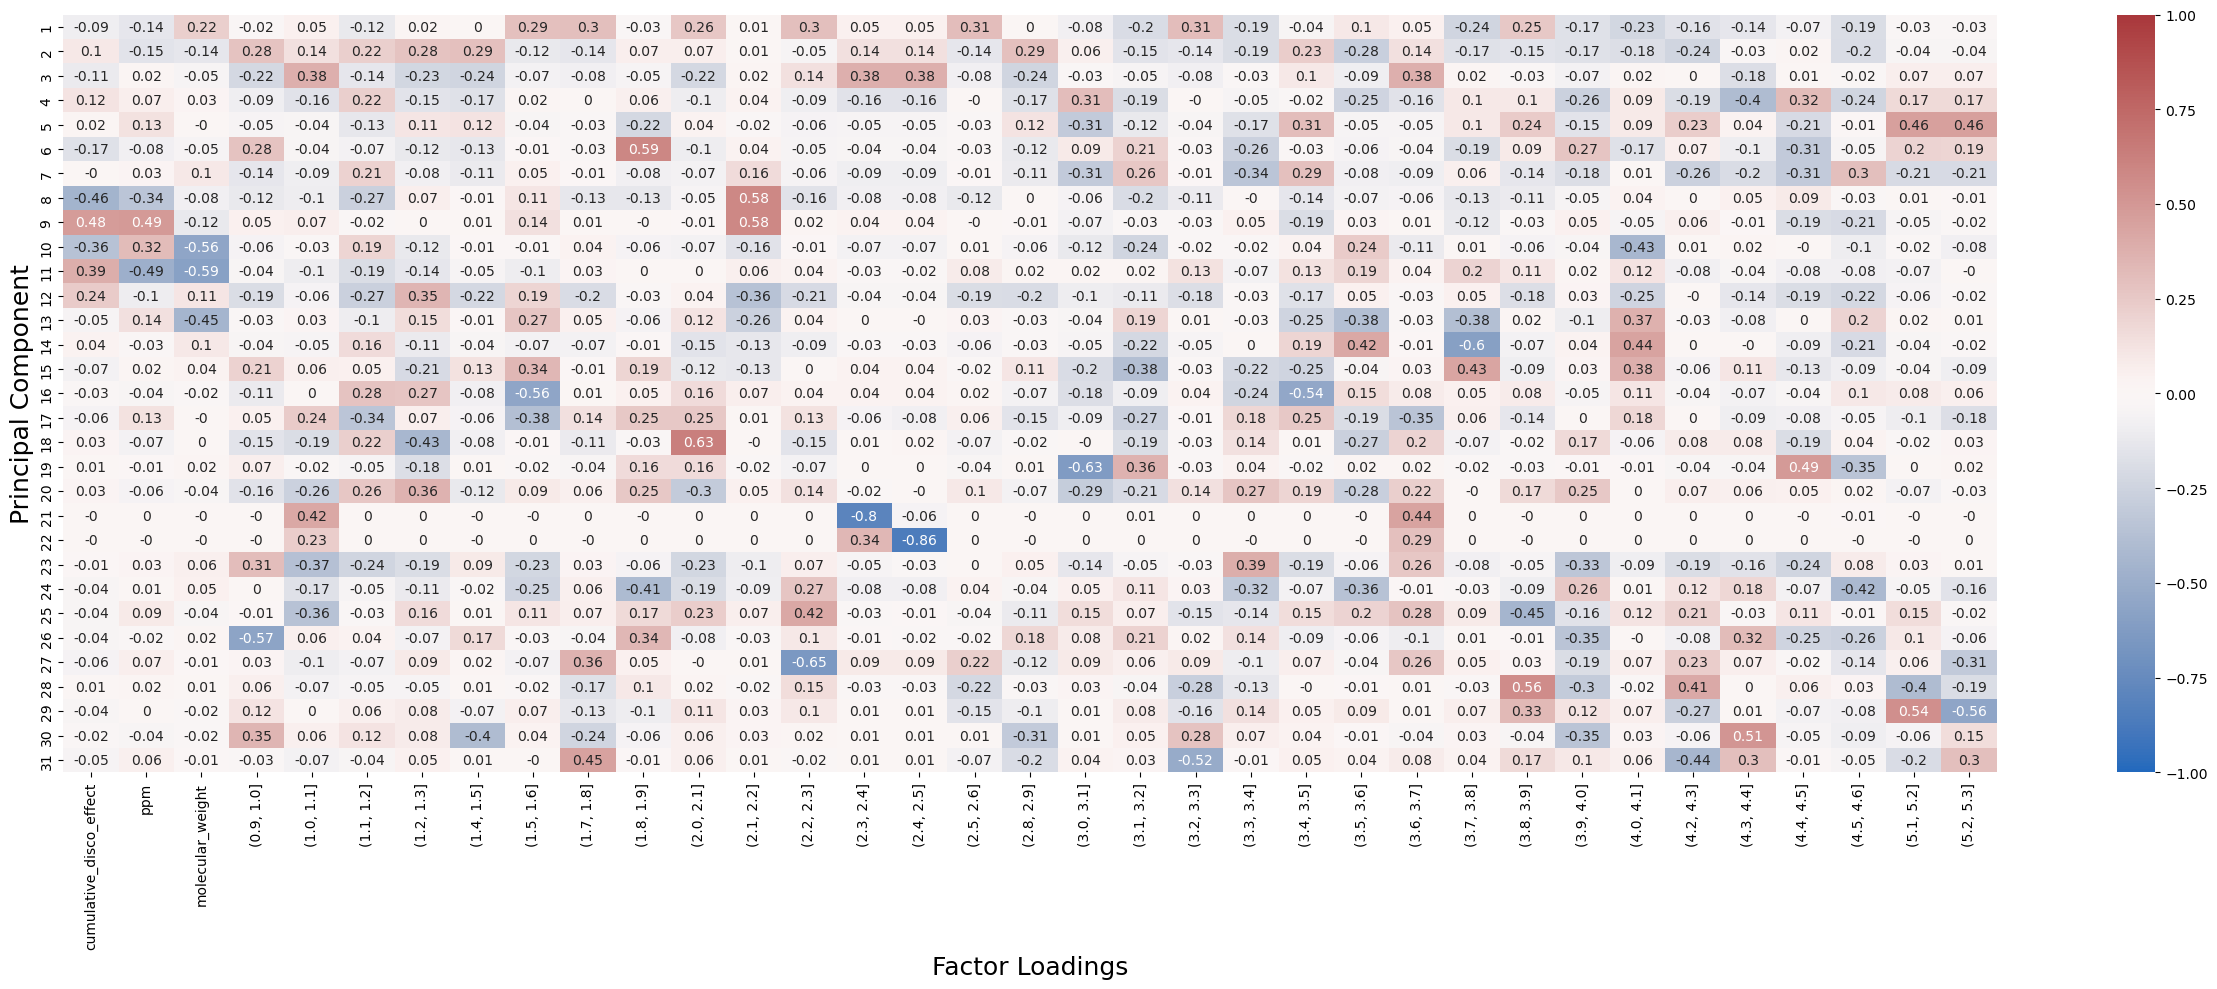

In [118]:
loadings_pc_df = pd.DataFrame(factor_loadings, columns = factornames, index = pc_ids)

fig, ax = plt.subplots(figsize=(25, 10))
sns.heatmap(loadings_pc_df.round(2), ax=ax, annot=True, cmap=sns.color_palette("vlag", as_cmap=True), vmin=-1.0, vmax=1.0)
plt.ylabel("Principal Component", fontsize=18)
plt.xlabel("Factor Loadings", fontsize=18)
plt.tight_layout()
# save as png, svg
plt.savefig("../figures/supplementary/factorloadings.png", dpi=1200)
plt.savefig("../figures/supplementary/factorloadings.svg", dpi=1200)
plt.show()


### 4.0 Execute Modelling Pipeline

The pipeline has the following steps:

<b> 1. Generate Cumulative DISCO Effect (CDE) Feature </b>

* CDE is generated by performing a first-pass principal component analysis on only the mean absolute DISCO Effect(t) features, retaining 1 component 
* This is achieved using a ColumnTransformer step (preprocess pipe) to avoid data leakage between training and validation sets in the global pipeline

<b> 2. Generate Final Principal Components </b>
* Standardize dataset (CDE + other features) (zero mean, 1 std)
* Principal component analysis (CDE + other features) 
* Optimal retained number of PCs selected by Minka's MLE

<b> 3. Grid Search Cross Validate to Construct Final Model </b>

* Apply Stratified 5-Fold Grid Search Cross Validation
* Stratification mitigates class imbalance
* Automatically outputs best performing model in terms of cross validated AUC
* Optimal predicted probability threshold is computed for best model (max true pos rate, min false pos rate) 
* If dataset changes, decision tree hyperparameter grid may require updating to suit the needs of the new dataset


In [119]:
cv = StratifiedKFold(n_splits = 5, shuffle = False)

model = DecisionTreeClassifier(random_state=148)

params = [{
    'dt__max_depth': [4, 5, 6, 7, 8, 9, 10],
    'dt__min_samples_split': [2, 3, 5, 7, 10, 15, 20, 30, 40],
    'dt__min_samples_leaf':[1, 2, 3, 5, 7, 10, 15, 20]
}]


In [120]:
X_model_pipe = Pipeline([
    ('preprocess', preprocess_pipe),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_components)),
    ('dt', model)])

In [121]:
pipeCV = GridSearchCV(X_model_pipe, params, scoring='roc_auc',
                      n_jobs=-1, cv=cv, refit=True, verbose=1)

In [122]:
print(X.shape, y.shape)

(99, 41) (99,)


### 3.0 Construct Final Model with GridSearch Cross Validation:

In [123]:
# FIT FINAL MODEL -----------------------------------------
pipeCV.fit(X=X, y=y)

# OPTIMIZE FINAL MODEL THRESHOLD DURING SEARCH --------------------------------------------
# https://datascience.stackexchange.com/questions/89880/classification-threshold-tuning-with-gridsearchcv 
preds = pipeCV.predict_proba(X)[:,1]
fpr, tpr, thresholds = roc_curve(y, preds)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# grab the fully trained preds 
all_train_preds = preds
all_model_preds = (pipeCV.predict_proba(X)[:, 1] >= optimal_threshold).astype(int)
all_pred_probs = pipeCV.predict_proba(X)[:, 1]

Fitting 5 folds for each of 504 candidates, totalling 2520 fits


In [124]:
final_model = pipeCV.best_estimator_.named_steps['dt']
print(final_model)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=3, random_state=148)


In [125]:
# final model cross validated AUC 
print("Cross validated final model AUC:")
print(pipeCV.best_score_)

Cross validated final model AUC:
0.6354166666666666


In [126]:
from sklearn.metrics import roc_auc_score
print("Fully trained descriptive model AUC:")
roc_auc_score(y, all_model_preds, average=None)


Fully trained descriptive model AUC:


0.9523809523809523

In [127]:
# final model optimal predicted probability threshold
print(optimal_threshold)

0.2


### Final Model Visualization:

In [128]:
X_final_model_pipe = Pipeline([
    ('preprocess', preprocess_pipe),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_components)),
    ])

X_plot = X_final_model_pipe.fit_transform(X)
pc_ids_plot = ["PC " + str(pc_id) for pc_id in pc_ids]

In [129]:
final_model_viz = pipeCV.best_estimator_.named_steps['dt']
final_model_viz.fit(X_plot, y)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=3, random_state=148)

### Generate simplified decision tree plot:

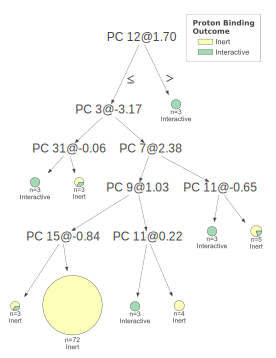

In [130]:
simpleviz = dtreeviz(final_model_viz,
               x_data=X_plot,
               y_data=y,
               target_name='Proton Binding\nOutcome',
               feature_names=pc_ids_plot,
               class_names=['Inert', 'Interactive'],
               fancy=False,
               histtype='bar',
               show_node_labels=False,
               colors={'classes':colors_for_2_classes},
               )
simpleviz

In [38]:
simpleviz.save(filename="../figures/main/simpletree.svg")

# convert to png
cairosvg.svg2png(url="../figures/main/simpletree.svg",
                 write_to='../figures/main/simpletree.png')

### Generate complex decision tree plot:

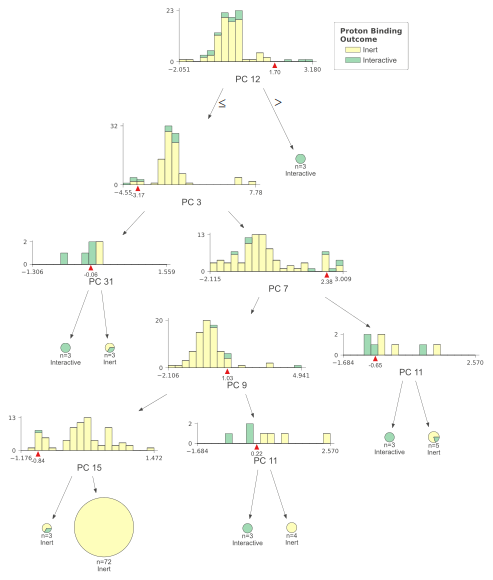

In [131]:
complex_viz = dtreeviz(final_model,
               x_data=X_plot,
               y_data=y,
               target_name='Proton Binding\nOutcome',
               feature_names=pc_ids_plot,
               class_names=['Inert', 'Interactive'],
               fancy=True,
               show_node_labels=False,
               colors={'classes': colors_for_2_classes,
                       'wedge': custom_colors[3]}
               )
complex_viz


In [40]:
# export svg
complex_viz.save(filename="../figures/main/fulltree.svg")

# convert to png
cairosvg.svg2png(url="../figures/main/fulltree.svg",
                 write_to='../figures/main/fulltree.png', 
                 parent_width=8.5, parent_height=11, dpi=1200, scale=4)

### 4.0 View fully trained performance metrics:


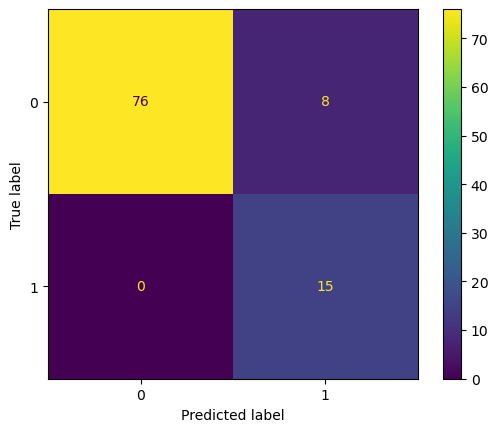

In [132]:
fully_trained_proton_clfrep = classification_report(y, all_model_preds, target_names=["0", "1"], output_dict=True)
fully_trained_proton_cm = confusion_matrix(y, all_model_preds, labels=[0, 1])

disp = ConfusionMatrixDisplay(confusion_matrix=fully_trained_proton_cm, display_labels=[0, 1])

# display fully trained metrics inline
disp.plot()
plt.show()


In [133]:
print(classification_report(y, all_model_preds,target_names=["0", "1"], output_dict=False))


              precision    recall  f1-score   support

           0       1.00      0.90      0.95        84
           1       0.65      1.00      0.79        15

    accuracy                           0.92        99
   macro avg       0.83      0.95      0.87        99
weighted avg       0.95      0.92      0.93        99



In [134]:
all_data_score_df = pd.DataFrame({"ytrue": y, "ypred": all_model_preds,
                                "dec_threshold": optimal_threshold})

<b>Plot Fully Trained Model Performance Summary:</b>

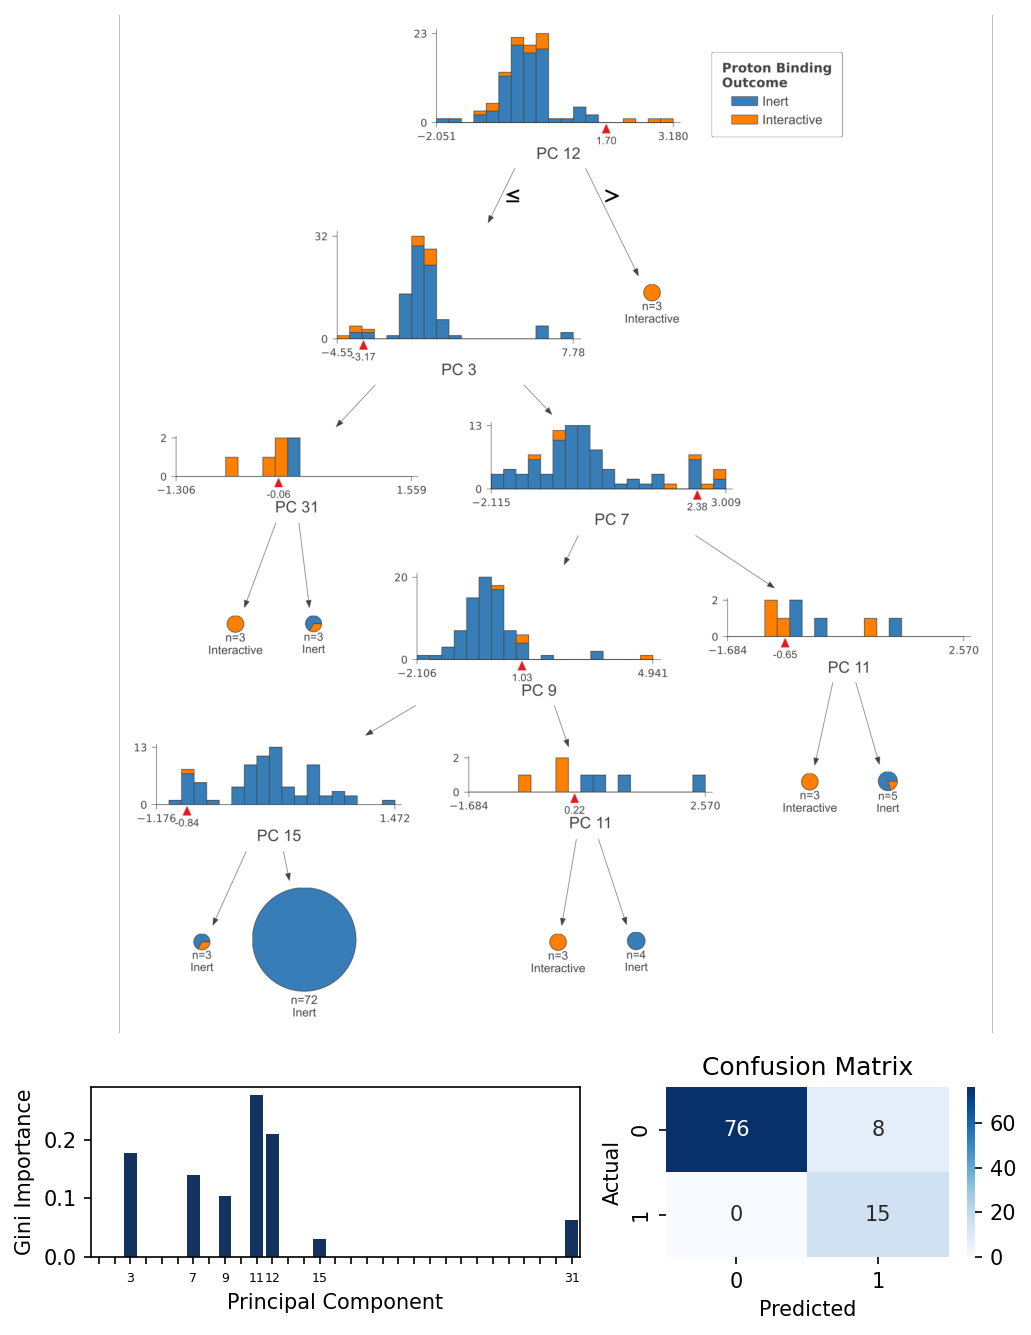

In [135]:
mosaic = """
    AAAA
    BBCC
    """

gs_kw = dict(width_ratios=[2, 1, 1, 1], height_ratios=[3, 0.5])

fig, axd = plt.subplot_mosaic(mosaic,
                              gridspec_kw=gs_kw, figsize=(7, 9),
                              constrained_layout=False, dpi=150)

path = "../figures/main/fulltree.png"
tree_image = Image.open(path)

# Tree Structure Axis
axd['A'].imshow(np.asarray(tree_image))
axd['A'].axis('off')
axd['A'].xaxis.set_visible(False)
axd['A'].yaxis.set_visible(False)

# feature importance plot
# custom axis labels
feat_imp_labels = np.zeros(len(pc_ids))
feat_imp_labels[2] = 3
feat_imp_labels[6] = 7
feat_imp_labels[8] = 9
feat_imp_labels[11] = 12
feat_imp_labels[10] = 11
feat_imp_labels[14] = 15
feat_imp_labels[30] = 31

feat_imp_labels = [label for label in feat_imp_labels]
feat_imp_labels = [int(num) if num != 0 else ' ' for num in feat_imp_labels]

feat_imp_df = pd.DataFrame([final_model.feature_importances_], columns=pc_ids)
sns.barplot(data=feat_imp_df, orient='v', ax=axd['B'], color='#08306b')
axd['B'].set_xticklabels(feat_imp_labels, fontsize=6)
axd['B'].set_xlabel("Principal Component")
axd['B'].set_ylabel("Gini Importance")

# confusion matrix
sns.heatmap(pd.DataFrame(fully_trained_proton_cm), annot=True,
            ax=axd['C'], cmap=sns.color_palette("Blues", as_cmap=True))
axd['C'].set_yticklabels(['0', '1'])
axd['C'].set_xticklabels(['0', '1'])
axd['C'].set_xlabel('Predicted')
axd['C'].set_ylabel('Actual')
axd['C'].set_title("Confusion Matrix")

fig.patch.set_facecolor('white')
plt.tight_layout()

# save as png, svg
plt.savefig("../figures/main/tree_summary.png", dpi=1200)
plt.savefig("../figures/main/tree_summary.svg", dpi=1200)
plt.show()


### 5.0 Tree Interpretation

Examine decisions and proton properties to construct structure-activity heuristics to improve our scientific understanding of mucoadhesion.



In [136]:
# format polymer names for readability
interpretable_df['polymer_name'] = interpretable_df['polymer_name'].astype(str)
interpretable_df.loc[df['polymer_name'] == "HPMCE4M_86k_20uM", ('polymer_name')] = "HPMC_86k_20uM" # rename for consistency
interpretable_df.loc[df['polymer_name'] == 'PEOX_50k_40uM', ('polymer_name')] = 'PEOZ_50k_40uM' # rename for consistency
interpretable_df.loc[df['polymer_name'] == "Poloxamer407_13k_50uM", ('polymer_name')] = "P407_13k_50uM" # rename for consistency
interpretable_df.loc[df['polymer_name'] == 'Dextran_150k_20uM', ('polymer_name')] = 'DEX_150k_20uM' # rename for consistency
interpretable_df.loc[df['polymer_name'] == 'PVA86-89_105k_20uM', ('polymer_name')] = 'PVA_105k_20uM' # rename for consistency

# load for lookup
proton_id = interpretable_df['polymer_name'].astype(str) + "_" + interpretable_df['ppm'].astype(str)
loadings_pc_df = pd.DataFrame(pipeCV.best_estimator_.named_steps['pca'].components_, index = pc_ids, columns = factornames)

display(interpretable_df.head())
print(interpretable_df.polymer_name.unique())

,polymer_name,concentration,ppm_bin,corr_%_attenuation0.25,corr_%_attenuation0.5,corr_%_attenuation0.75,corr_%_attenuation1.0,corr_%_attenuation1.25,corr_%_attenuation1.5,corr_%_attenuation1.75,...,"(3.7, 3.8]","(3.8, 3.9]","(3.9, 4.0]","(4.0, 4.1]","(4.2, 4.3]","(4.3, 4.4]","(4.4, 4.5]","(4.5, 4.6]","(5.1, 5.2]","(5.2, 5.3]"
0,DEX_150k_20uM,20,"(5.2, 5.3]",0.015418,0.002828,-0.004538,0.002257,-0.009912,-0.016120,0.003645,...,1,1,0,1,1,0,0,0,1,0
1,DEX_150k_20uM,20,"(5.1, 5.2]",0.095602,-0.013616,-0.048097,0.029934,-0.162398,-0.090247,-0.036158,...,1,1,0,1,1,0,0,0,0,1
2,HPC_370k_20uM,20,"(4.5, 4.6]",0.065708,0.024242,0.033384,0.079823,0.094301,0.080398,0.087829,...,1,0,0,1,0,0,0,0,0,0
3,HPC_80k_20uM,20,"(4.5, 4.6]",-0.481986,-0.273215,-0.018844,-0.711022,-0.137549,-0.370218,-0.393501,...,1,0,0,1,0,0,0,0,0,0
4,CMC_131k_20uM,20,"(4.5, 4.6]",-0.001168,-0.032334,-0.026764,-0.026776,-0.042765,-0.047105,-0.053642,...,1,0,1,1,1,1,0,0,0,0


['DEX_150k_20uM' 'HPC_370k_20uM' 'HPC_80k_20uM' 'CMC_131k_20uM'
 'CMC_90k_20uM' 'HPMC_120k_20uM' 'HPMC_86k_20uM' 'PDMAEMA_10k_200uM'
 'PVA_105k_20uM' 'PHPMA_40k_20uM' 'PVP_55k_20uM' 'PVP_1300k_20uM'
 'P407_13k_50uM' 'PEG_10k_20uM' 'PEG_20k_20uM' 'PEG_2k_20uM'
 'PEOZ_50k_40uM' 'PAA_450k_20uM']


In [137]:
# define pipeline for interpretability assessment
X_preprocess_pipe = Pipeline([('preprocess', preprocess_pipe), ('scaler', StandardScaler()), ('pca', PCA(n_components=n_components))])

Transform data for plotting, add interpretable lookups:

In [138]:
cde_lookup = preprocess_pipe.fit_transform(X)[:,0]
full_dataset = X_preprocess_pipe.fit_transform(X)
full_dataset = pd.DataFrame(full_dataset, columns=pc_ids)
full_dataset.columns = [int(col) for col in full_dataset.columns]

In [139]:
full_dataset['bind'] = y
full_dataset['proton_id'] = proton_id
full_dataset['proton_id'] = full_dataset['proton_id'].apply(lambda x: x.split("_", -1)[0] +" "+ x.split("_",-1)[1] + " " + x.split("_", -1)[-1])
full_dataset['polymer_id'] = full_dataset['proton_id'].apply(lambda x: x.split(" ", -1)[0] + " " + x.split(" ", -1)[1])
full_dataset['cumulative_disco_effect'] = cde_lookup
interpretable_df['cumulative_disco_effect'] = full_dataset['cumulative_disco_effect']

display(full_dataset)


,1,2,3,4,5,6,7,8,9,10,...,26,27,28,29,30,31,bind,proton_id,polymer_id,cumulative_disco_effect
0,-0.999466,-1.115870,1.003302,1.575295,4.158194,0.652134,-0.522251,-0.307714,0.181140,0.476091,...,0.197120,1.395722,0.781612,2.442013,-0.618599,-1.158836,0,DEX 150k 5.3,DEX 150k,-0.816311
1,-1.127432,-0.944165,0.810657,1.765522,4.181328,0.355623,-0.531070,-1.102460,1.037843,-0.359105,...,-0.543444,-0.250732,1.682463,-2.235001,0.235491,0.837733,0,DEX 150k 5.2,DEX 150k,2.661424
2,-1.668193,0.272917,0.163540,1.242616,0.505409,-0.490374,2.356668,-1.551581,0.506367,-0.505067,...,0.476540,0.361670,-0.079237,0.231052,0.200395,0.174299,0,HPC 370k 4.58,HPC 370k,2.299962
3,-2.364552,0.960831,-0.468964,1.913776,0.631278,-1.478066,2.250786,-4.179127,3.414968,-2.178025,...,0.237184,0.036615,-0.017256,0.001706,0.094849,-0.086280,0,HPC 80k 4.58,HPC 80k,15.256992
4,-2.782468,-2.724262,-0.499486,-1.969359,-0.096656,-0.246832,-1.279249,-0.460316,1.099423,0.103996,...,0.517974,0.352675,-0.072689,0.207708,0.217742,0.153993,1,CMC 131k 4.58,CMC 131k,0.704265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,-1.283382,-0.288102,0.486339,-0.152379,0.315218,0.023413,2.526569,0.634572,-2.106313,-1.617642,...,-0.058021,0.028978,0.013404,-0.018877,-0.109298,0.019819,1,HPC 370k 1.13,HPC 370k,-0.766740
95,0.002084,0.377325,0.480477,0.075534,0.314884,-0.022305,0.990359,1.006114,-1.317203,1.137804,...,-0.058476,0.030578,0.018983,0.056492,-0.074745,0.055515,0,P407 13k 1.19,P407 13k,-1.074831
96,1.717517,3.150584,6.212907,-2.057031,-0.590075,-0.161091,-0.386944,0.105467,-0.819495,-0.657273,...,-0.284404,0.337499,0.268949,0.087231,-0.167135,0.266957,0,PEOZ 50k 1.01,PEOZ 50k,-1.259477
97,-1.095044,1.106102,-0.507347,1.026620,-3.242205,4.402033,-0.275770,-0.268763,-0.822604,-0.586440,...,1.695774,-0.169760,-0.262763,-0.246007,-0.958096,0.056074,0,PHPMA 40k 0.94,PHPMA 40k,-0.060591


Generate lookups for PC explained variance ratio and PC factor loadings for downstream heuristic interpretation:

In [140]:
expvar_lookup = X_preprocess_pipe.named_steps['pca'].explained_variance_ratio_
display(expvar_lookup)
display(loadings_pc_df.head())

array([0.20925527, 0.14576834, 0.11783437, 0.089422  , 0.08343197,
       0.05313099, 0.04329296, 0.03921139, 0.029534  , 0.01847257,
       0.01630218, 0.01531547, 0.0125748 , 0.00874277, 0.00771763,
       0.00751404, 0.00666779, 0.00653872, 0.00649833, 0.00641902,
       0.00601826, 0.00601824, 0.00585898, 0.00580937, 0.00561753,
       0.00550228, 0.00538368, 0.0051693 , 0.00514234, 0.00489921,
       0.00488181])

,cumulative_disco_effect,ppm,molecular_weight,"(0.9, 1.0]","(1.0, 1.1]","(1.1, 1.2]","(1.2, 1.3]","(1.4, 1.5]","(1.5, 1.6]","(1.7, 1.8]",...,"(3.7, 3.8]","(3.8, 3.9]","(3.9, 4.0]","(4.0, 4.1]","(4.2, 4.3]","(4.3, 4.4]","(4.4, 4.5]","(4.5, 4.6]","(5.1, 5.2]","(5.2, 5.3]"
1,-0.086786,-0.141611,0.215737,-0.020975,0.045024,-0.118674,0.015361,0.003717,0.291401,0.304538,...,-0.236301,0.248714,-0.166304,-0.228252,-0.163428,-0.139375,-0.073564,-0.185410,-0.028861,-0.029601
2,0.095993,-0.151389,-0.142022,0.277704,0.139783,0.216184,0.278830,0.290074,-0.119233,-0.143335,...,-0.173166,-0.148595,-0.173989,-0.183279,-0.235799,-0.029100,0.016534,-0.196189,-0.044454,-0.043029
3,-0.114898,0.024905,-0.054026,-0.224456,0.381750,-0.135934,-0.227431,-0.239665,-0.070765,-0.076897,...,0.020249,-0.026131,-0.065741,0.019345,0.002638,-0.181797,0.007269,-0.019066,0.071467,0.069489
4,0.117361,0.073435,0.025734,-0.092839,-0.159359,0.217153,-0.152506,-0.172266,0.018593,0.000542,...,0.101482,0.102060,-0.264864,0.086990,-0.192819,-0.396281,0.319366,-0.243060,0.170316,0.172889
5,0.021081,0.130315,-0.001612,-0.049217,-0.043799,-0.132660,0.108969,0.122791,-0.039349,-0.033174,...,0.100543,0.240651,-0.150899,0.087524,0.232925,0.041553,-0.207193,-0.014661,0.456729,0.457065


### SI Plot: Heuristic 3 - Within PDMAEMA

In [141]:
pdmaema_leaf = full_dataset.copy()
pdmaema_leaf = pdmaema_leaf.loc[np.logical_and(pdmaema_leaf[12] <= 1.70, pdmaema_leaf[3] <= -3.17)]

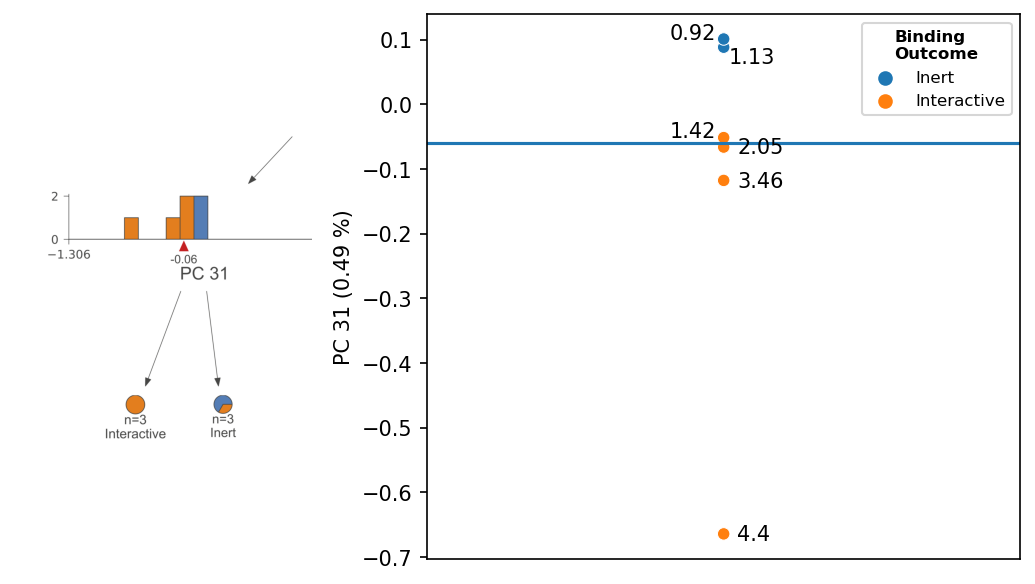

In [142]:
mosaic = """
    AB
    """

gs_kw = dict(width_ratios=[0.5,1], height_ratios=[1])

fig, axd = plt.subplot_mosaic(mosaic,
                              gridspec_kw=gs_kw, figsize=(7, 4),
                              constrained_layout=False, dpi=150)
annot_size = 5

path = "../figures/misc/pc31.png"
tree_image = Image.open(path)

# Tree Structure Axis
axd['A'].imshow(np.asarray(tree_image))
axd['A'].axis('off')
axd['A'].xaxis.set_visible(False)
axd['A'].yaxis.set_visible(False)


g=sns.scatterplot(x=0, y=pdmaema_leaf[31], ax=axd['B'], hue = pdmaema_leaf['bind'])
axd['B'].get_xaxis().set_visible(False)
axd['B'].set_ylabel(f"PC 31 ({str(np.round(expvar_lookup[30],4)*100)} %)")

legend_labels, _ = axd['B'].get_legend_handles_labels()
g.legend(legend_labels, ['Inert', 'Interactive'], 
          loc='upper right', title_fontproperties={'weight': 'bold', 'size':8},
         title='Binding\nOutcome', fontsize=8)

for ix, proton in pdmaema_leaf.iterrows():
    ppm = proton['proton_id'].split(' ',-1)[-1]

    if ppm == '0.92':
        axd['B'].text(s=ppm, x=0-0.01, y=proton[31])
    
    elif ppm == '1.13':
        axd['B'].text(s=ppm, x=+0.001, y=proton[31]-0.025)

    elif ppm == '1.42':
        axd['B'].text(s=ppm, x=0-0.01, y=proton[31])

    else:
        axd['B'].text(s=ppm, x=0+0.0025, y=proton[31]-0.01)

axd['B'].axhline(y=-0.06)

# save as png, svg
plt.tight_layout()
plt.savefig("../figures/supplementary/pdmaema_31.png", dpi=150)
plt.savefig("../figures/supplementary/pdmaema_31.svg", dpi=150)

plt.show()


### Heuristics 1, 2, 5: PAA, PDMAEMA, HPC

In [143]:
third_root_node_df = full_dataset.copy()
third_root_node_df = third_root_node_df.loc[np.logical_and(third_root_node_df[12] <= 1.7, third_root_node_df[3]>-3.171)]
display(third_root_node_df)

,1,2,3,4,5,6,7,8,9,10,...,26,27,28,29,30,31,bind,proton_id,polymer_id,cumulative_disco_effect
0,-0.999466,-1.115870,1.003302,1.575295,4.158194,0.652134,-0.522251,-0.307714,0.181140,0.476091,...,0.197120,1.395722,0.781612,2.442013,-0.618599,-1.158836,0,DEX 150k 5.3,DEX 150k,-0.816311
1,-1.127432,-0.944165,0.810657,1.765522,4.181328,0.355623,-0.531070,-1.102460,1.037843,-0.359105,...,-0.543444,-0.250732,1.682463,-2.235001,0.235491,0.837733,0,DEX 150k 5.2,DEX 150k,2.661424
2,-1.668193,0.272917,0.163540,1.242616,0.505409,-0.490374,2.356668,-1.551581,0.506367,-0.505067,...,0.476540,0.361670,-0.079237,0.231052,0.200395,0.174299,0,HPC 370k 4.58,HPC 370k,2.299962
3,-2.364552,0.960831,-0.468964,1.913776,0.631278,-1.478066,2.250786,-4.179127,3.414968,-2.178025,...,0.237184,0.036615,-0.017256,0.001706,0.094849,-0.086280,0,HPC 80k 4.58,HPC 80k,15.256992
4,-2.782468,-2.724262,-0.499486,-1.969359,-0.096656,-0.246832,-1.279249,-0.460316,1.099423,0.103996,...,0.517974,0.352675,-0.072689,0.207708,0.217742,0.153993,1,CMC 131k 4.58,CMC 131k,0.704265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,-1.457066,-0.178309,0.545814,-0.188034,0.314126,0.082347,2.441282,0.752291,-2.061250,-1.098789,...,-0.067736,0.044028,0.001243,0.003477,-0.089852,0.031521,0,HPC 80k 1.13,HPC 80k,-1.023336
94,-1.283382,-0.288102,0.486339,-0.152379,0.315218,0.023413,2.526569,0.634572,-2.106313,-1.617642,...,-0.058021,0.028978,0.013404,-0.018877,-0.109298,0.019819,1,HPC 370k 1.13,HPC 370k,-0.766740
95,0.002084,0.377325,0.480477,0.075534,0.314884,-0.022305,0.990359,1.006114,-1.317203,1.137804,...,-0.058476,0.030578,0.018983,0.056492,-0.074745,0.055515,0,P407 13k 1.19,P407 13k,-1.074831
96,1.717517,3.150584,6.212907,-2.057031,-0.590075,-0.161091,-0.386944,0.105467,-0.819495,-0.657273,...,-0.284404,0.337499,0.268949,0.087231,-0.167135,0.266957,0,PEOZ 50k 1.01,PEOZ 50k,-1.259477


### Heuristics 4/5 HPC

In [144]:
hpc_leaf = third_root_node_df.copy()
hpc_leaf = hpc_leaf.loc[hpc_leaf[7] > 2.384]

### Combined Heuristics 1,2 PAA PDMAEMA:

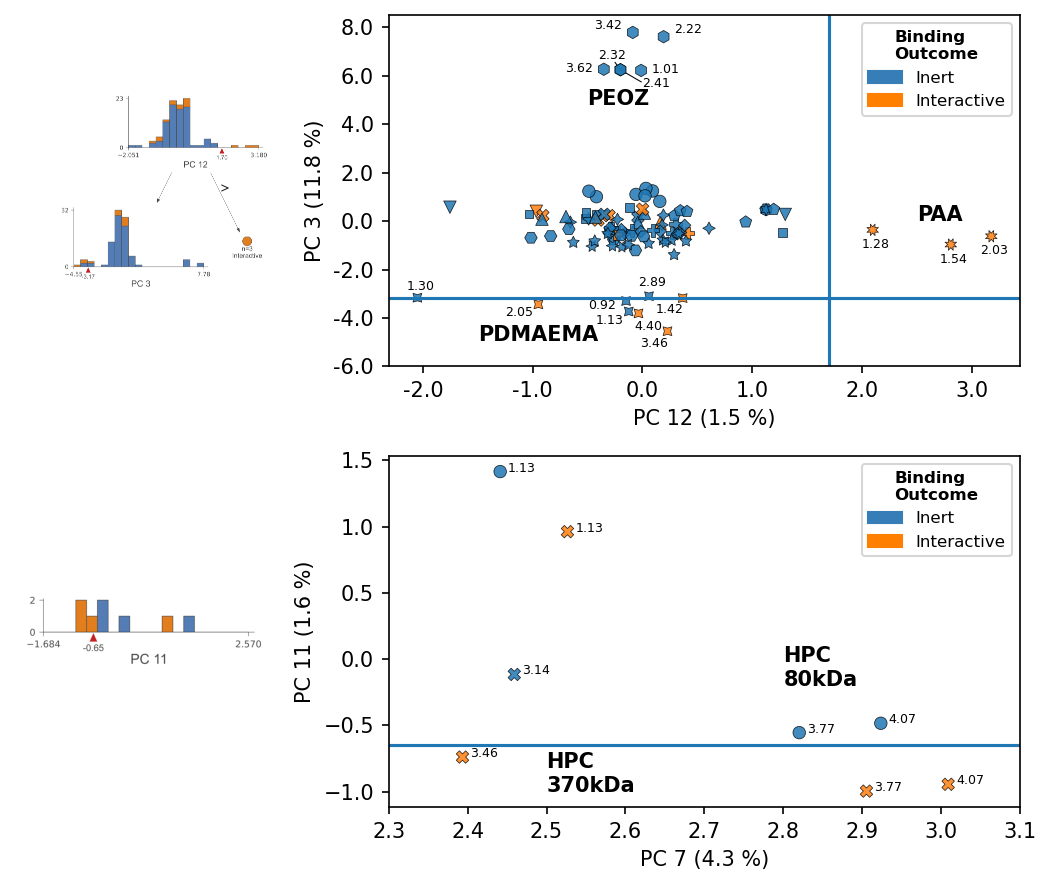

In [145]:
mosaic = """
    CDD
    BHH
    """

gs_kw = dict(width_ratios=[1, 1, 1], height_ratios=[1, 1])

fig, axd = plt.subplot_mosaic(mosaic,
                              gridspec_kw=gs_kw, figsize=(7, 6),
                              constrained_layout=False, dpi=150)

annot_size = 6

path = "../figures/misc/pc11.png"
tree_image_hpc = Image.open(path)

# Tree Structure Axis
axd['B'].imshow(np.asarray(tree_image_hpc))
axd['B'].axis('off')
axd['B'].xaxis.set_visible(False)
axd['B'].yaxis.set_visible(False)

path = "../figures/misc/pc12pc3.png"
tree_image_pdmaema = Image.open(path)

# Tree Structure Axis
axd['C'].imshow(np.asarray(tree_image_pdmaema))
axd['C'].axis('off')
axd['C'].xaxis.set_visible(False)
axd['C'].yaxis.set_visible(False)

# add PAA PC Plot
g = sns.scatterplot(data=full_dataset, x=12, y=3, hue='bind', 
            edgecolor='k', linewidth=0.35, ax = axd['D'], style = 'polymer_id', alpha = 0.85)

#create artist items to build legend manually
inert_patches = mpatches.Patch(color=custom_colors[0], label = 'Inert')
interactive_patches = mpatches.Patch(color = custom_colors[2], label = 'Interactive')

g.legend(handles = [inert_patches,interactive_patches],
          loc='upper right', title_fontproperties={'weight': 'bold', 'size':8},
         title='Binding\nOutcome', fontsize=8)

axd['D'].axvline(x=1.7)
axd['D'].axhline(y=-3.171)
axd['D'].set_ylim(-6, 8.5)

for ix, proton in full_dataset.iterrows():
    ppm = proton['proton_id'].split(' ', -1)[2]
    if proton[12] > 1.7:
        axd['D'].text(s=ppm, x=proton[12]-0.1, y=proton[3]-0.75, fontsize = annot_size)
            
    elif proton[3] <= -3: # -3.171
        ppm = proton['proton_id'].split(' ', -1)[2]
        if ppm == '2.05':
            axd['D'].text(s=ppm, x=proton[12]-0.3, y=proton[3]-0.5, fontsize = annot_size)
        elif ppm == '1.42':
            axd['D'].text(s=ppm, x=proton[12]-0.25, y=proton[3]-0.60, fontsize = annot_size)
        elif ppm == '4.4':
            axd['D'].text(s=ppm+'0', x=proton[12]-0.035, y=proton[3]-0.7, fontsize = annot_size)
        elif ppm == '0.92':
            axd['D'].text(s=ppm, x=proton[12]-0.35, y=proton[3]-0.35, fontsize = annot_size)
        elif ppm == '3.46':
            axd['D'].text(s=ppm, x=proton[12]-0.25, y=proton[3]-0.65, fontsize = annot_size)
        elif ppm == '1.13':
            axd['D'].text(s=ppm, x=proton[12]-0.3, y=proton[3]-0.5, fontsize = annot_size)
        elif ppm == '2.89':
            axd['D'].text(s=ppm, x=proton[12]-0.1, y=proton[3]+0.4, fontsize = annot_size)
        elif ppm == '1.3':
            axd['D'].text(s=ppm+'0', x=proton[12]-0.1, y=proton[3]+0.3, fontsize = annot_size)
            
    elif proton[3] >= 5:
        if ppm == '3.42':
            axd['D'].text(s=ppm, x=proton[12]-0.35, y=proton[3]+0.15, fontsize = annot_size)
        
        elif ppm == '2.22':
            axd['D'].text(s=ppm, x=proton[12]+0.1, y=proton[3]+0.15, fontsize = annot_size)
        
        elif ppm == '3.62':
            axd['D'].text(s=ppm, x=proton[12]-0.35, y=proton[3]-0.1, fontsize = annot_size)
        
        elif ppm == '2.41': 
            axd['D'].text(s=ppm, x=proton[12]+0.2, y=proton[3]-0.70, fontsize = annot_size)
            axd['D'].plot((proton[12]+0.19, proton[12]), (proton[3]-0.50, proton[3]), color = 'black', linewidth = 0.5, zorder=0)

        elif ppm == '2.32': 
            axd['D'].text(s=ppm, x=proton[12]-0.2, y=proton[3]+0.45, fontsize = annot_size)
            axd['D'].plot((proton[12]-0.05, proton[12]), (proton[3]+0.3, proton[3]), color = 'black',linewidth = 0.5, zorder=0)

        elif ppm == '1.01':
            axd['D'].text(s=ppm, x=proton[12]+0.10, y=proton[3]-0.1, fontsize = annot_size)

axd['D'].text(s="PAA", x=2.5, y=0, fontweight = 'bold')
axd['D'].text(s="PDMAEMA", x=-1.5, y=-4.95, fontweight='bold')
axd['D'].text(s="PEOZ", x=-0.5, y=4.8, fontweight='bold')
axd['D'].xaxis.set_major_formatter('{x:0<3.1f}')
axd['D'].yaxis.set_major_formatter('{x:0<3.1f}')

# ax labels
axd['D'].set_xlabel(f"PC 12 ({str(np.round(expvar_lookup[11],3)*100)} %)") # data type issue adding string
axd['D'].set_ylabel(f"PC 3 (11.8 %)")


# HPC Plot

# add PC Plot
h = sns.scatterplot(data=hpc_leaf, x=7, y=11, hue='bind', 
                    edgecolor='k', linewidth=0.35, ax=axd['H'], style = 'polymer_id',alpha = 0.85)

#legend_labels, _ = axd['H'].get_legend_handles_labels()

h.legend(handles = [inert_patches,interactive_patches],
         loc='upper right', title_fontproperties={'weight': 'bold', 'size':8},
         title='Binding\nOutcome', fontsize=8)

axd['H'].axhline(y=-0.647)
axd['H'].set_xlim(2.3, 3.1)

for ix, proton in hpc_leaf.iterrows():
    ppm = proton['proton_id'].split(' ', -1)[2]
    if proton[7] > 2.3:
        # axd['D'].text(s=ppm, x=proton[7], y=proton[9])
        if proton['proton_id'].replace(" ", "") == 'HPC80k1.13':
            axd['H'].text(s=ppm, x=proton[7]+0.01, y=proton[11], fontsize = annot_size)

        elif proton['proton_id'].replace(" ", "") == 'HPC370k1.13':
            axd['H'].text(s=ppm, x=proton[7]+0.01, y=proton[11], fontsize = annot_size)

        elif proton['proton_id'].replace(" ", "") == 'HPC370k3.14':
            axd['H'].text(s=ppm, x=proton[7]+0.01, y=proton[11], fontsize = annot_size)

        elif proton['proton_id'].replace(" ", "") == 'HPC370k3.46':
            axd['H'].text(s=ppm, x=proton[7]+0.01, y=proton[11], fontsize = annot_size)

        elif proton['proton_id'].replace(" ", "") == 'HPC370k3.77':
            axd['H'].text(s=ppm, x=proton[7]+0.01, y=proton[11], fontsize = annot_size)

        elif proton['proton_id'].replace(" ", "") == 'HPC80k3.77':
            axd['H'].text(s=ppm, x=proton[7]+0.01, y=proton[11], fontsize = annot_size)

        elif proton['proton_id'].replace(" ", "") == 'HPC370k4.07':
            axd['H'].text(s=ppm, x=proton[7]+0.01, y=proton[11], fontsize = annot_size)

        elif proton['proton_id'].replace(" ", "") == 'HPC80k4.07':
            axd['H'].text(s=ppm, x=proton[7]+0.01, y=proton[11], fontsize = annot_size)

axd['H'].text(s="HPC\n370kDa", x=2.5, y=-1, fontweight = 'bold')
axd['H'].text(s="HPC\n80kDa", x=2.8, y=-0.2, fontweight='bold')

# ax labels
axd['H'].set_xlabel(f"PC 7 ({str(np.round(expvar_lookup[6],3)*100)} %)")
axd['H'].set_ylabel(f"PC 11 ({str(np.round(expvar_lookup[10],3)*100)} %)")

fig.patch.set_facecolor('white')
plt.tight_layout()

# save as png, svg
plt.savefig("../figures/main/paa_pdmaema_hpc.png", dpi=1200)
plt.savefig("../figures/main/paa_pdmaema_hpc.svg", dpi=1200)
plt.show()


### Heuristic 5 Summary Stats:

In [146]:
bind_hpc_index = hpc_leaf.loc[hpc_leaf[11] <= -0.647,:].index
inert_hpc_index = hpc_leaf.loc[hpc_leaf[11] > -0.647, :].index

Average proton properties on either side of decision rule:

In [147]:
interpretable_df.loc[bind_hpc_index,['cumulative_disco_effect','ppm','molecular_weight']].mean()

cumulative_disco_effect     -0.737094
ppm                          3.766667
molecular_weight           370.000000
dtype: float64

In [148]:
interpretable_df.loc[inert_hpc_index, ['cumulative_disco_effect', 'ppm', 'molecular_weight']].mean()


cumulative_disco_effect     -0.619655
ppm                          2.648000
molecular_weight           196.000000
dtype: float64

### SI: Heuristic 4 PC7 Visual

In [149]:
third_root_node_df

,1,2,3,4,5,6,7,8,9,10,...,26,27,28,29,30,31,bind,proton_id,polymer_id,cumulative_disco_effect
0,-0.999466,-1.115870,1.003302,1.575295,4.158194,0.652134,-0.522251,-0.307714,0.181140,0.476091,...,0.197120,1.395722,0.781612,2.442013,-0.618599,-1.158836,0,DEX 150k 5.3,DEX 150k,-0.816311
1,-1.127432,-0.944165,0.810657,1.765522,4.181328,0.355623,-0.531070,-1.102460,1.037843,-0.359105,...,-0.543444,-0.250732,1.682463,-2.235001,0.235491,0.837733,0,DEX 150k 5.2,DEX 150k,2.661424
2,-1.668193,0.272917,0.163540,1.242616,0.505409,-0.490374,2.356668,-1.551581,0.506367,-0.505067,...,0.476540,0.361670,-0.079237,0.231052,0.200395,0.174299,0,HPC 370k 4.58,HPC 370k,2.299962
3,-2.364552,0.960831,-0.468964,1.913776,0.631278,-1.478066,2.250786,-4.179127,3.414968,-2.178025,...,0.237184,0.036615,-0.017256,0.001706,0.094849,-0.086280,0,HPC 80k 4.58,HPC 80k,15.256992
4,-2.782468,-2.724262,-0.499486,-1.969359,-0.096656,-0.246832,-1.279249,-0.460316,1.099423,0.103996,...,0.517974,0.352675,-0.072689,0.207708,0.217742,0.153993,1,CMC 131k 4.58,CMC 131k,0.704265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,-1.457066,-0.178309,0.545814,-0.188034,0.314126,0.082347,2.441282,0.752291,-2.061250,-1.098789,...,-0.067736,0.044028,0.001243,0.003477,-0.089852,0.031521,0,HPC 80k 1.13,HPC 80k,-1.023336
94,-1.283382,-0.288102,0.486339,-0.152379,0.315218,0.023413,2.526569,0.634572,-2.106313,-1.617642,...,-0.058021,0.028978,0.013404,-0.018877,-0.109298,0.019819,1,HPC 370k 1.13,HPC 370k,-0.766740
95,0.002084,0.377325,0.480477,0.075534,0.314884,-0.022305,0.990359,1.006114,-1.317203,1.137804,...,-0.058476,0.030578,0.018983,0.056492,-0.074745,0.055515,0,P407 13k 1.19,P407 13k,-1.074831
96,1.717517,3.150584,6.212907,-2.057031,-0.590075,-0.161091,-0.386944,0.105467,-0.819495,-0.657273,...,-0.284404,0.337499,0.268949,0.087231,-0.167135,0.266957,0,PEOZ 50k 1.01,PEOZ 50k,-1.259477


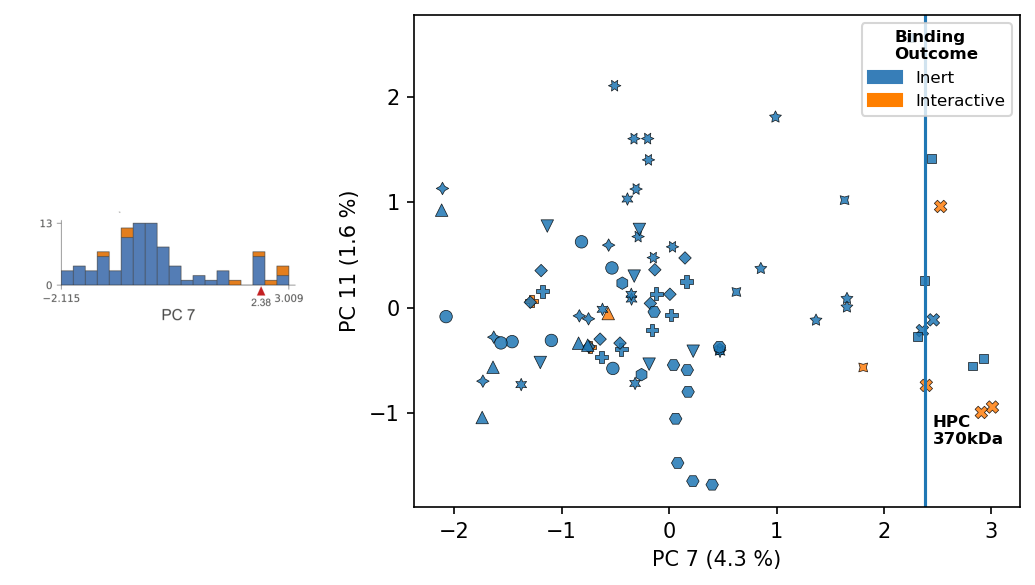

In [180]:
mosaic = """
    AB
    """

gs_kw = dict(width_ratios=[0.5,1], height_ratios=[1])

fig, axd = plt.subplot_mosaic(mosaic,
                              gridspec_kw=gs_kw, figsize=(7, 4),
                              constrained_layout=False, dpi=150)

g = sns.scatterplot(data = third_root_node_df, x=7, y=11, ax=axd['B'], hue=third_root_node_df['bind'], style = 'polymer_id',alpha = 0.85, 
                    edgecolor='k', linewidth=0.35,)

annot_size = 5

path = "../figures/misc/pc7.png"
tree_image = Image.open(path)

# Tree Structure Axis
axd['A'].imshow(np.asarray(tree_image))
axd['A'].axis('off')
axd['A'].xaxis.set_visible(False)
axd['A'].yaxis.set_visible(False)

#create artist items to build legend manually
inert_patches = mpatches.Patch(color=custom_colors[0], label = 'Inert')
interactive_patches = mpatches.Patch(color = custom_colors[2], label = 'Interactive')

g.legend(handles = [inert_patches,interactive_patches],
          loc='upper right', title_fontproperties={'weight': 'bold', 'size':8},
         title='Binding\nOutcome', fontsize=8)



axd['B'].axvline(x=2.384)
axd['B'].text(s="HPC\n370kDa", x=2.45, y=-1.3, fontsize = 8, fontweight = 'bold')
axd['B'].text(s="HPC\n80kDa", x=2.55, y=1.5, fontsize = 8, fontweight = 'bold')

# ax labels
axd['B'].set_xlabel(f"PC 7 ({str(np.round(expvar_lookup[6],3)*100)} %)")
axd['B'].set_ylabel(f"PC 11 ({str(np.round(expvar_lookup[10],3)*100)} %)")


# save as png, svg
plt.tight_layout()
plt.savefig("../figures/supplementary/pc7_h4.png", dpi=150)
plt.savefig("../figures/supplementary/pc7_h4.svg", dpi=150)

plt.show()


### Heuristics 6, 7, 8 Cross Species Trends

In [152]:
third_root_node_df_subset = third_root_node_df.copy()  
third_root_node_df_subset = third_root_node_df_subset.loc[third_root_node_df_subset[7] <= 2.384]

In [153]:
dominant_protons  = third_root_node_df_subset.copy()
dominant_protons = dominant_protons.loc[dominant_protons[9] > 1.031]

secondary_protons = third_root_node_df_subset.copy()
secondary_protons = secondary_protons.loc[secondary_protons[9] <= 1.031]

In [154]:
non_dominant_protons = third_root_node_df_subset.copy().drop(dominant_protons.index)

interpretable_df.loc[non_dominant_protons.index, ['molecular_weight', 'ppm', 'cumulative_disco_effect']].mean()


molecular_weight           212.266667
ppm                          3.143867
cumulative_disco_effect     -0.409864
dtype: float64

In [155]:
interpretable_df.loc[dominant_protons.index, ['molecular_weight','ppm','cumulative_disco_effect']].mean()

molecular_weight           111.000000
ppm                          4.140000
cumulative_disco_effect      3.633591
dtype: float64

In [156]:
print(dominant_protons['cumulative_disco_effect'].mean())
print(secondary_protons['cumulative_disco_effect'].mean())


3.6335908335581655
-0.40986381418879364


Heuristic 7:


In [157]:
dominant_interactive = dominant_protons.copy()
dominant_interactive = dominant_interactive.loc[dominant_interactive[11] < 0.22]
dominant_inert = dominant_protons.loc[dominant_protons[11] > 0.22]
display(dominant_interactive)


,1,2,3,4,5,6,7,8,9,10,...,26,27,28,29,30,31,bind,proton_id,polymer_id,cumulative_disco_effect
4,-2.782468,-2.724262,-0.499486,-1.969359,-0.096656,-0.246832,-1.279249,-0.460316,1.099423,0.103996,...,0.517974,0.352675,-0.072689,0.207708,0.217742,0.153993,1,CMC 131k 4.58,CMC 131k,0.704265
7,-2.006252,-0.000378,-0.082683,2.442341,-1.160661,-1.196856,-0.565501,-0.975256,1.034050,-0.071752,...,0.743047,0.115298,-0.222550,0.302281,0.190058,0.094668,1,HPMC 86k 4.48,HPMC 86k,2.629580
16,0.877759,0.156335,0.403070,0.995850,-0.324040,0.630284,1.806460,5.288399,4.941262,0.046426,...,-0.106329,-0.068102,-0.003554,0.073100,0.011416,0.019183,1,PVA 105k 4.08,PVA 105k,-1.221515


In [158]:
interpretable_df.loc[dominant_interactive.index, ['ppm','molecular_weight','cumulative_disco_effect']].mean()


ppm                          4.380000
molecular_weight           107.333333
cumulative_disco_effect      0.704110
dtype: float64

In [159]:
interpretable_df.loc[dominant_inert.index, ['ppm', 'molecular_weight', 'cumulative_disco_effect']].mean()


ppm                          3.960000
molecular_weight           113.750000
cumulative_disco_effect      5.830702
dtype: float64

DEX 150k 5.2 1.0378431511137791 0.377643031901767
HPC 80k 4.58 3.4149680161425358 2.570130976205068
CMC 131k 4.58 1.0994229611853414 0.06227008577017861
CMC 90k 4.58 1.0138216974434608 0.051391432565846516
HPMC 120k 4.48 1.892038674241829 0.5946046648639602
HPMC 86k 4.48 1.03405048300114 -0.05608439191432942
PVA 105k 4.08 4.941262175038703 -0.5686100512584227
PVP 55k 3.89 0.989799304400278 0.5783032857126039
PEOZ 50k 3.42 1.0285506864766951 -0.7315897100145493
PVA 105k 1.58 3.3800890718608403 1.0223917871280335


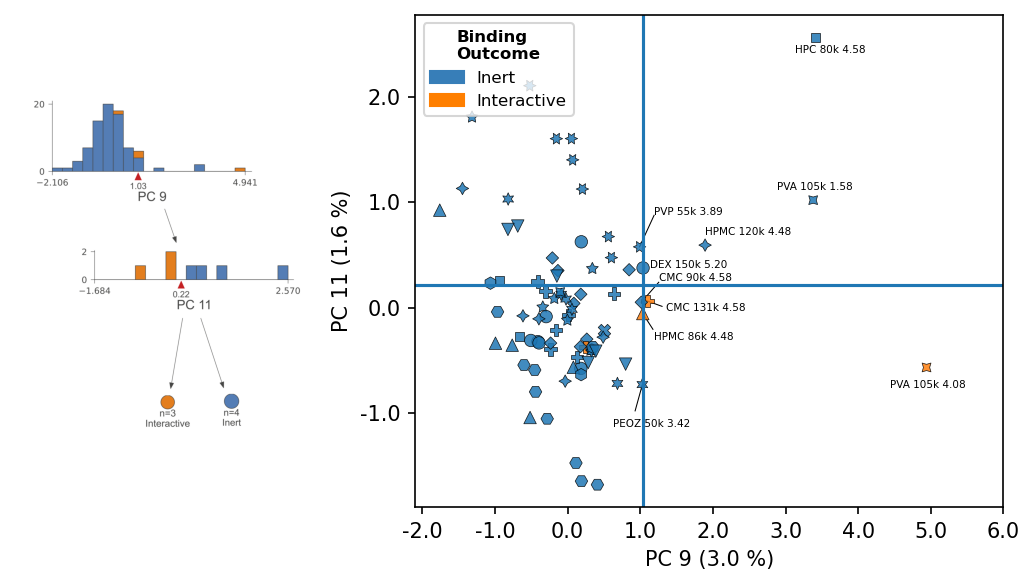

In [163]:
mosaic = """
    AD
    """

gs_kw = dict(width_ratios=[0.5,1], height_ratios=[1])

fig, axd = plt.subplot_mosaic(mosaic,
                              gridspec_kw=gs_kw, figsize=(7, 4),
                              constrained_layout=False, dpi=150)
annot_size = 5
path = "../figures/misc/pc911.png"
tree_image_pva = Image.open(path)

# Tree Structure Axis
axd['A'].imshow(np.asarray(tree_image_pva))
axd['A'].axis('off')
axd['A'].xaxis.set_visible(False)
axd['A'].yaxis.set_visible(False)


# add PC Plot
g = sns.scatterplot(data=third_root_node_df_subset, x=9, y=11, hue='bind', edgecolor='k', linewidth=0.35, ax = axd['D'], style = 'polymer_id',alpha=0.85)

#create artist items to build legend manually
inert_patches = mpatches.Patch(color=custom_colors[0], label = 'Inert')
interactive_patches = mpatches.Patch(color = custom_colors[2], label = 'Interactive')

g.legend(handles = [inert_patches,interactive_patches],
          loc='upper left', title_fontproperties={'weight': 'bold', 'size':8},
         title='Binding\nOutcome', fontsize=8)

axd['D'].axhline(y=0.22)
axd['D'].axvline(x=1.031)

for ix, proton in third_root_node_df_subset.iterrows():
    ppm = proton['proton_id'].split(' ', -1)[2]

    if proton[9] > 0.98: 
        print(proton['proton_id'], proton[9], proton[11])

        if proton['proton_id'].replace(" ", "") == 'DEX150k5.2':
            axd['D'].text(s=proton['proton_id']+'0', x=proton[9]+0.1, y=proton[11], fontsize = annot_size)
        
        elif proton['proton_id'].replace(" ", "") == 'CMC131k4.58':
            axd['D'].text(s=proton['proton_id'], x=proton[9]+0.25, y=proton[11]-0.09, fontsize = annot_size)
            axd['D'].plot((proton[9]+0.2, proton[9]), (proton[11]-0.05,
                          proton[11]), color='black', linewidth=0.5, zorder=0)

        elif proton['proton_id'].replace(" ", "") == 'HPMC120k4.48':
            axd['D'].text(s=proton['proton_id'], x=proton[9], y=proton[11]+0.1, fontsize = annot_size)
        
        elif proton['proton_id'].replace(" ", "") == 'HPMC86k4.48':
            axd['D'].text(s=proton['proton_id'], x=proton[9]+0.15, y=proton[11]-0.25, fontsize = annot_size)
            axd['D'].plot((proton[9]+0.14, proton[9]), (proton[11]-0.15, proton[11]), color='black', linewidth=0.5, zorder=0)

        elif proton['proton_id'].replace(" ", "") == 'PVA105k4.08':
            axd['D'].text(s=proton['proton_id'], x=proton[9]-0.5, y=proton[11]-0.2, fontsize = annot_size)

        elif proton['proton_id'].replace(" ", "") == 'PVA105k1.58':
            axd['D'].text(s=proton['proton_id'], x=proton[9]-0.5, y=proton[11]+0.1, fontsize = annot_size)

        elif proton['proton_id'].replace(" ", "") == 'HPC80k4.58':
            axd['D'].text(s=proton['proton_id'], x=proton[9]-0.28, y=proton[11]-0.15, fontsize = annot_size)
                
        # borderline protons 
        elif proton['proton_id'].replace(" ", "") == 'CMC90k4.58':
            axd['D'].text(s=proton['proton_id'], x=proton[9]+0.25, y=proton[11]+0.2, fontsize = annot_size)
            axd['D'].plot((proton[9]+0.24, proton[9]), (proton[11]+0.19, proton[11]), color='black', linewidth=0.5, zorder=0)

        elif proton['proton_id'].replace(" ", "") == 'PEOZ50k3.42':
            axd['D'].text(s=proton['proton_id'], x=proton[9]-0.40, y=proton[11]-0.4, fontsize = annot_size)
            axd['D'].plot((proton[9]-0.1, proton[9]), (proton[11]-0.25,
                          proton[11]), color='black', linewidth=0.5, zorder=0)

        elif proton['proton_id'].replace(" ", "") == 'PVP55k3.89':
            axd['D'].text(s=proton['proton_id'], x=proton[9]+0.2, y=proton[11]+0.3, fontsize = annot_size)
            axd['D'].plot((proton[9]+0.2, proton[9]), (proton[11]+0.3,
                          proton[11]), color='black', linewidth=0.5, zorder=0)
        
# ax labels
axd['D'].set_xlabel(f"PC 9 ({str(np.round(expvar_lookup[8],3)*100)} %)")
axd['D'].set_ylabel(f"PC 11 ({str(np.round(expvar_lookup[10],3)*100)} %)")
axd['D'].xaxis.set_major_formatter('{x:0<3.1f}')
axd['D'].yaxis.set_major_formatter('{x:0<3.1f}')

plt.xlim(-2.1,6)
fig.patch.set_facecolor('white')
plt.tight_layout()

# save as png, svg
plt.savefig("../figures/main/cross_polymer_h67.png", dpi=1200)
plt.savefig("../figures/main/cross_polymer_h67.svg", dpi=1200)

plt.show()


In [164]:
inert_junction = third_root_node_df_subset.copy()
inert_junction = inert_junction.loc[inert_junction[9]<=1.031]

In [165]:
print(inert_junction['cumulative_disco_effect'].mean())

-0.40986381418879364


DEX 150k 5.3
HPC 370k 4.58
CMC 90k 4.58
CMC 131k 4.36
CMC 90k 4.36
CMC 90k 4.25
CMC 131k 4.25
DEX 150k 4.22
CMC 90k 3.94
CMC 131k 3.93
PHPMA 40k 3.92
PVP 55k 3.89
DEX 150k 3.88
PVP 1300k 3.89
PEG 10k 3.7
PEG 20k 3.7
PEG 2k 3.7
PEOZ 50k 3.62
P407 13k 3.54
CMC 131k 3.58
PVP 55k 3.6
CMC 90k 3.58
P407 13k 3.6
PVP 1300k 3.6
DEX 150k 3.48
PEOZ 50k 3.42
HPC 80k 3.46
P407 13k 3.47
CMC 131k 3.35
HPMC 120k 3.38
CMC 90k 3.35
HPMC 86k 3.38
PVP 1300k 3.22
PVP 55k 3.22
PHPMA 40k 3.19
CMC 90k 3.14
HPC 80k 3.14
CMC 131k 3.14
HPMC 120k 3.08
HPMC 86k 3.08
PHPMA 40k 3.04
PDMAEMA 10k 2.89
PVP 55k 2.51
PVP 1300k 2.51
PEOZ 50k 2.41
PEOZ 50k 2.32
PVP 1300k 2.27
PVP 55k 2.27
PEOZ 50k 2.22
PVA 105k 2.12
PVP 55k 2.03
PVP 1300k 2.03
PVP 55k 1.78
PVP 1300k 1.78
PDMAEMA 10k 1.3
PHPMA 40k 1.16
HPMC 120k 1.16
HPMC 86k 1.16
P407 13k 1.19
PEOZ 50k 1.01


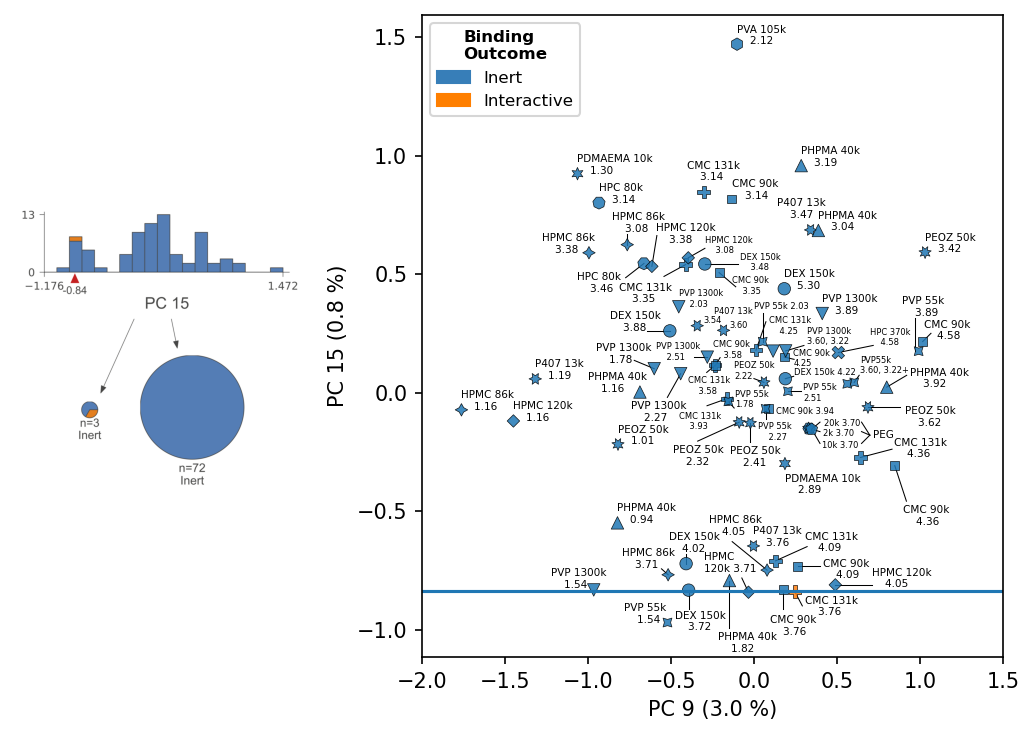

In [166]:
mosaic = """
    AD
    """

gs_kw = dict(width_ratios=[0.5,1], height_ratios=[1])

fig, axd = plt.subplot_mosaic(mosaic,
                              gridspec_kw=gs_kw, figsize=(7, 5),
                              constrained_layout=False, dpi=150)
# annot_size = 3.0
annot_size = 5.0
annot_size2 = 4.0

path = "../figures/misc/pc15.png"
tree_image_peg = Image.open(path)

# Tree Structure Axis
axd['A'].imshow(np.asarray(tree_image_peg))
axd['A'].axis('off')
axd['A'].xaxis.set_visible(False)
axd['A'].yaxis.set_visible(False)

# add PC Plot
g = sns.scatterplot(data=inert_junction, x=9, y=15, hue='bind', edgecolor='k', linewidth=0.35, ax = axd['D'], style = 'polymer_id', alpha = 0.85)

#create artist items to build legend manually
inert_patches = mpatches.Patch(color=custom_colors[0], label = 'Inert')
interactive_patches = mpatches.Patch(color = custom_colors[2], label = 'Interactive')

g.legend(handles = [inert_patches,interactive_patches],
          loc='upper left', title_fontproperties={'weight': 'bold', 'size':8},
         title='Binding\nOutcome', fontsize=8)


axd['D'].axhline(y=-0.836)

for ix, proton in inert_junction.iterrows():
    ppm = proton['proton_id'].split(' ', -1)[2]

    if proton[15] < -0.5:
        plot_id = proton['proton_id'].replace('k ', 'k\n    ')

        if proton['proton_id'].replace(" ", "") == 'CMC131k3.76':
            axd['D'].text(s=plot_id, x=proton[9]+0.06, y=proton[15]-0.1, fontsize = annot_size)
            axd['D'].plot((proton[9]+0.045, proton[9]), (proton[15]-0.06, proton[15]), color='black', linewidth=0.5, zorder=0)

        elif proton['proton_id'].replace(" ", "") == 'CMC131k4.09':
            axd['D'].text(s=plot_id, x=proton[9]+0.18, y=proton[15]+0.04, fontsize=annot_size)
            axd['D'].plot((proton[9]+0.19, proton[9]), (proton[15]+0.06, proton[15]), color='black', linewidth=0.5, zorder=0)
        
        elif proton['proton_id'].replace(" ", "") == 'CMC90k3.76':
            axd['D'].text(s=plot_id, x=proton[9]-0.08, y=proton[15]-0.19, fontsize=annot_size)
            axd['D'].plot((proton[9], proton[9]), (proton[15]-0.08, proton[15]), color='black', linewidth=0.5, zorder=0)
        
        elif proton['proton_id'].replace(" ", "") == 'CMC90k4.09':
            axd['D'].text(s=plot_id, x=proton[9]+0.15, y=proton[15]-0.05, fontsize=annot_size)
            axd['D'].plot((proton[9]+0.135, proton[9]), (proton[15], proton[15]), color='black', linewidth=0.5, zorder=0)
            

        elif proton['proton_id'].replace(" ", "") == 'DEX150k3.72':
            axd['D'].text(s=plot_id, x=proton[9]-0.08, y=proton[15]-0.17, fontsize=annot_size)
            axd['D'].plot((proton[9], proton[9]), (proton[15]-0.08, proton[15]), color='black', linewidth=0.5, zorder=0)

        elif proton['proton_id'].replace(" ", "") == 'DEX150k4.02':
            axd['D'].text(s=plot_id, x=proton[9]-0.1, y=proton[15]+0.05, fontsize=annot_size)
            axd['D'].plot((proton[9], proton[9]), (proton[15]+0.04, proton[15]), color='black', linewidth=0.5, zorder=0)
            
        elif proton['proton_id'].replace(" ", "") == 'HPMC120k3.71':
            plot_id = proton['proton_id'].replace('120k ', '\n120k ')
            axd['D'].text(s=plot_id, x=proton[9]-0.27, y=proton[15]+0.085, fontsize=annot_size)
            axd['D'].plot((proton[9]-0.04, proton[9]), (proton[15]+0.06, proton[15]), color='black', linewidth=0.5, zorder=0)

               
        elif proton['proton_id'].replace(" ", "") == 'HPMC86k3.71':
            axd['D'].text(s=plot_id, x=proton[9]-0.28, y=proton[15]+0.03, fontsize=annot_size)
            axd['D'].plot((proton[9]-0.04, proton[9]), (proton[15]+0.025, proton[15]), color='black', linewidth=0.5, zorder=0)
    
        elif proton['proton_id'].replace(" ", "") == 'HPMC86k4.05':
                    axd['D'].text(s=plot_id, x=proton[9]-0.35, y=proton[15]+0.15, fontsize=annot_size)
                    axd['D'].plot((proton[9]-0.21, proton[9]), (proton[15]+0.12, proton[15]), color='black', linewidth=0.5, zorder=-1)

        elif proton['proton_id'].replace(" ", "") == 'PVP1300k1.54':
            axd['D'].text(s=plot_id, x=proton[9]-0.26, y=proton[15]+0.01, fontsize=annot_size)

        elif proton['proton_id'].replace(" ", "") == 'PVP55k1.54':
            axd['D'].text(s=plot_id, x=proton[9]-0.26, y=proton[15], fontsize=annot_size)

        elif proton['proton_id'].replace(" ", "") == 'HPMC120k4.05':
            axd['D'].text(s=plot_id, x=proton[9]+0.22, y=proton[15]-0.01, fontsize=annot_size)
            axd['D'].plot((proton[9]+0.22, proton[9]), (proton[15], proton[15]), color='black', linewidth=0.5, zorder=0)

        elif proton['proton_id'].replace(" ", "") == 'PHPMA40k1.82':
            axd['D'].text(s=plot_id, x=proton[9]-0.07, y=proton[15]-0.30, fontsize=annot_size)
            axd['D'].plot((proton[9], proton[9]), (proton[15]-0.20, proton[15]), color='black', linewidth=0.5, zorder=0)

        else:
            axd['D'].text(s=plot_id, x=proton[9], y=proton[15], fontsize = annot_size)
        
    else:
        plot_id = proton['proton_id'].replace('k ', 'k\n    ')
        print(proton['proton_id']) 
 
        if proton['proton_id'].replace(" ", "") == 'P40713k3.47':
            axd['D'].text(s=plot_id, x=proton[9]-0.20,
                          y=proton[15]+0.05, fontsize=annot_size)
                          
        elif proton['proton_id'].replace(" ", "") == 'PVP55k3.6':
            axd['D'].text(s='PVP55k\n3.60, 3.22+', x=proton[9]+0.033, y=proton[15]+0.04, fontsize=annot_size2)
            axd['D'].plot((proton[9]+0.03, proton[9]), (proton[15]+0.03, proton[15]), color='black', linewidth=0.5, zorder=0)

        elif proton['proton_id'].replace(" ", "") == 'CMC131k3.14':
            axd['D'].text(s=plot_id, x=proton[9]-0.1, y=proton[15]+0.05, fontsize=annot_size)

        elif proton['proton_id'].replace(" ", "") == 'CMC131k3.35':
            axd['D'].text(s=plot_id, x=proton[9]-0.40, y=proton[15]-0.16, fontsize=annot_size)
            axd['D'].plot((proton[9]-0.13, proton[9]), (proton[15]-0.05, proton[15]), color='black', linewidth=0.5, zorder=0)
        
        elif proton['proton_id'].replace(" ", "") == 'CMC131k4.25':
            axd['D'].text(s=plot_id, x=proton[9]+0.08, y=proton[15]+0.07, fontsize=annot_size2)
            axd['D'].plot((proton[9]+0.06, proton[9]), (proton[15]+0.12, proton[15]), color='black', linewidth=0.5, zorder=0)
            
        elif proton['proton_id'].replace(" ", "") == 'DEX150k3.48':
            axd['D'].text(s=plot_id, x=proton[9]+0.21, y=proton[15]-0.025, fontsize=annot_size2)
            axd['D'].plot((proton[9]+0.20, proton[9]), (proton[15], proton[15]), color='black', linewidth=0.5, zorder=0)

        elif proton['proton_id'].replace(" ", "") == 'DEX150k3.88':
            axd['D'].text(s=plot_id, x=proton[9]-0.36, y=proton[15], fontsize=annot_size)
            axd['D'].plot((proton[9]-0.14, proton[9]), (proton[15], proton[15]), color='black', linewidth=0.5, zorder=0)

        elif proton['proton_id'].replace(" ", "") == 'CMC90k3.35':
            axd['D'].text(s=plot_id, x=proton[9]+0.08, y=proton[15]-0.09, fontsize=annot_size2)
            axd['D'].plot((proton[9]+0.1, proton[9]), (proton[15]-0.06, proton[15]), color='black', linewidth=0.5, zorder=0)

        elif proton['proton_id'].replace(" ", "") == 'CMC131k3.93':
            axd['D'].text(s=plot_id, x=proton[9]-0.29, y=proton[15]-0.13, fontsize=annot_size2)
            axd['D'].plot((proton[9]-0.12, proton[9]), (proton[15]-0.03, proton[15]), color='black', linewidth=0.5, zorder=0)

        elif proton['proton_id'].replace(" ", "") == 'CMC90k3.58':
            axd['D'].text(s=plot_id, x=proton[9]-0.01, y=proton[15]+0.035, fontsize=annot_size2)
            axd['D'].plot((proton[9]+0.03, proton[9]), (proton[15]+0.035, proton[15]), color='black', linewidth=0.5, zorder=0)
        
        elif proton['proton_id'].replace(" ", "") == 'CMC90k4.25':
            axd['D'].text(s='CMC 90k\n4.25', x=proton[9]+0.055, y=proton[15]-0.038, fontsize=annot_size2)
            axd['D'].plot((proton[9]+0.06, proton[9]), (proton[15]-0.01, proton[15]), color='black', linewidth=0.5, zorder=0)

        elif proton['proton_id'].replace(" ", "") == 'CMC90k4.36':
            axd['D'].text(s=plot_id, x=proton[9]+0.05, y=proton[15]-0.25, fontsize=annot_size)
            axd['D'].plot((proton[9]+0.07, proton[9]), (proton[15]-0.15, proton[15]), color='black', linewidth=0.5, zorder=0)

        elif proton['proton_id'].replace(" ", "") == 'CMC131k4.36':
            axd['D'].text(s=plot_id, x=proton[9]+0.20, y=proton[15], fontsize=annot_size)
            axd['D'].plot((proton[9]+0.19, proton[9]), (proton[15]+0.035, proton[15]), color='black', linewidth=0.5, zorder=0)

        elif proton['proton_id'].replace(" ", "") == 'CMC131k3.58':
            axd['D'].text(s=plot_id, x=proton[9]-0.165, y=proton[15]-0.12, fontsize=annot_size2)
            axd['D'].plot((proton[9]-0.05, proton[9]), (proton[15]-0.03, proton[15]), color='black', linewidth=0.5, zorder=0)
        
        elif proton['proton_id'].replace(" ", "") == 'HPMC86k3.38':
            axd['D'].text(s=plot_id, x=proton[9]-0.28, y=proton[15], fontsize=annot_size)

        elif proton['proton_id'].replace(" ", "") == 'HPMC86k3.08':
            axd['D'].text(s=plot_id, x=proton[9]-0.09, y=proton[15]+0.055, fontsize=annot_size)
            axd['D'].plot((proton[9], proton[9]), (proton[15]+0.045, proton[15]), color='black', linewidth=0.5, zorder=0)

        elif proton['proton_id'].replace(" ", "") == 'HPC80k3.46':
            axd['D'].text(s=plot_id, x=proton[9]-0.4, y=proton[15]-0.12, fontsize=annot_size)
            axd['D'].plot((proton[9]-0.11, proton[9]), (proton[15]-0.06, proton[15]), color='black', linewidth=0.5, zorder=0)

        elif proton['proton_id'].replace(" ", "") == 'HPMC120k3.38':
            axd['D'].text(s=plot_id, x=proton[9]+0.025, y=proton[15]+0.1, fontsize=annot_size)
            axd['D'].plot((proton[9]+0.03, proton[9]), (proton[15]+0.13, proton[15]), color='black', linewidth=0.5, zorder=0)

        elif proton['proton_id'].replace(" ", "") == 'HPMC120k3.08':
            axd['D'].text(s=plot_id, x=proton[9]+0.1, y=proton[15]+0.02, fontsize=annot_size2)
            axd['D'].plot((proton[9]+0.1, proton[9]), (proton[15]+0.04, proton[15]), color='black', linewidth=0.5, zorder=0)
        
        elif proton['proton_id'].replace(" ", "") == 'PVP55k2.03':
            axd['D'].text(s='PVP 55k 2.03', x=proton[9]-0.05, y=proton[15]+0.14, fontsize=annot_size2)
            axd['D'].plot((proton[9], proton[9]), (proton[15]+0.12, proton[15]), color='black', linewidth=0.5, zorder=0)
        
        elif proton['proton_id'].replace(" ", "") == 'PVP55k3.89':
            axd['D'].text(s=plot_id, x=proton[9]-0.10, y=proton[15]+0.15, fontsize=annot_size)
            axd['D'].plot((proton[9]-0.025, proton[9]-0.025), (proton[15]+0.14, proton[15]), color='black', linewidth=0.5, zorder=0)

        elif proton['proton_id'].replace(" ", "") == 'PVP1300k1.78':
            axd['D'].text(s=plot_id, x=proton[9]-0.35,
                          y=proton[15]+0.025, fontsize=annot_size)
            axd['D'].plot((proton[9]-0.12, proton[9]), (proton[15]+0.035, proton[15]), color='black', linewidth=0.5, zorder=0)

        elif proton['proton_id'].replace(" ", "") == 'PVP55k1.78':
            axd['D'].text(s='PVP 55k\n1.78', x=proton[9]+0.038,
                          y=proton[15]-0.025, fontsize=annot_size2)
            axd['D'].plot((proton[9]+0.035, proton[9]), (proton[15] -
                          0.028, proton[15]), color='black', linewidth=0.5, zorder=0)

        elif proton['proton_id'].replace(" ", "") == 'PVP1300k2.27':
            axd['D'].text(s=plot_id, x=proton[9]-0.30, y=proton[15]-0.20, fontsize=annot_size)
            axd['D'].plot((proton[9]-0.08, proton[9]), (proton[15]-0.1, proton[15]), color='black', linewidth=0.5, zorder=0)

        elif proton['proton_id'].replace(" ", "") == 'PVP1300k2.51':
            axd['D'].text(s=plot_id, x=proton[9]-0.31,
                          y=proton[15]-0.01, fontsize=annot_size2)
            axd['D'].plot((proton[9]-0.08, proton[9]), (proton[15], proton[15]), color='black', linewidth=0.5, zorder=0)

        elif proton['proton_id'].replace(" ", "") == 'PVP1300k3.22':
            axd['D'].text(s=' ', x=proton[9],
                          y=proton[15], fontsize=annot_size2)


        elif proton['proton_id'].replace(" ", "") == 'PVP1300k3.6':
            axd['D'].text(s='PVP 1300k\n3.60, 3.22', x=proton[9]+0.13, y=proton[15]+0.029, fontsize=annot_size2)
            axd['D'].plot((proton[9]+0.11, proton[9]), (proton[15]+0.023, proton[15]), color='black', linewidth=0.5, zorder=0)
            
        elif proton['proton_id'].replace(" ", "") == 'PVP55k3.22': 
            axd['D'].text(s=' ', x=proton[9], y=proton[15], fontsize=annot_size)
            
        
        elif proton['proton_id'].replace(" ", "") == 'PVP55k2.27':
            axd['D'].text(s=plot_id, x=proton[9]-0.045, y=proton[15]-0.13, fontsize=annot_size2)
            axd['D'].plot((proton[9], proton[9]), (proton[15] -0.045, proton[15]), color='black', linewidth=0.5, zorder=0)
        

        elif proton['proton_id'].replace(" ", "") == 'PVP55k2.51':
            axd['D'].text(s='PVP 55k\n2.51', x=proton[9]+0.09,
                          y=proton[15]-0.04, fontsize=annot_size2)
            axd['D'].plot((proton[9]+0.08, proton[9]), (proton[15], proton[15]), color='black', linewidth=0.5, zorder=0)

        elif proton['proton_id'].replace(" ", "") == 'PEG10k3.7':
            axd['D'].text(s='10k 3.70', x=proton[9]+0.08,
                          y=proton[15]-0.08, fontsize=annot_size2)

        elif proton['proton_id'].replace(" ", "") == 'PEG2k3.7':
            axd['D'].text(s='2k 3.70', x=proton[9]+0.07,y=proton[15]-0.028, fontsize=annot_size2)
            axd['D'].text(s='PEG', x=proton[9]+0.37, y=proton[15]-0.035, fontsize=annot_size)
            # LINES TO PEG TEXT
            axd['D'].plot((proton[9]+0.35, proton[9]+0.3), (proton[15]-0.025, proton[15]+0.03), color='black', linewidth=0.5, zorder=0)
            axd['D'].plot((proton[9]+0.35, proton[9]+0.3), (proton[15]-0.025, proton[15]-0.06), color='black', linewidth=0.5, zorder=0)
            axd['D'].plot((proton[9]+0.35, proton[9]+0.3), (proton[15]-0.025, proton[15]-0.01), color='black', linewidth=0.5, zorder=0)

            # LINES TO DOTS
            axd['D'].plot((proton[9]+0.05, proton[9]), (proton[15]+0.03, proton[15]), color='black', linewidth=0.5, zorder=0)
            axd['D'].plot((proton[9]+0.05, proton[9]), (proton[15]-0.06, proton[15]), color='black', linewidth=0.5, zorder=0)
            axd['D'].plot((proton[9]+0.05, proton[9]), (proton[15]-0.01, proton[15]), color='black', linewidth=0.5, zorder=0)

        elif proton['proton_id'].replace(" ", "") == 'PEG20k3.7':
            axd['D'].text(s='20k 3.70', x=proton[9]+0.09,
                          y=proton[15]+0.01, fontsize=annot_size2)

        elif proton['proton_id'].replace(" ", "") == 'PHPMA40k1.16':
            axd['D'].text(s=plot_id, x=proton[9]-0.31, y=proton[15], fontsize=annot_size)

        elif proton['proton_id'].replace(" ", "") == 'PHPMA40k3.92':
            axd['D'].text(s=plot_id, x=proton[9]+0.14, y=proton[15], fontsize=annot_size)
            axd['D'].plot((proton[9]+0.12, proton[9]), (proton[15]+0.05, proton[15]), color='black', linewidth=0.5, zorder=0)

        elif proton['proton_id'].replace(" ", "") == 'PEOZ50k2.22':
            axd['D'].text(s='PEOZ 50k\n2.22', x=proton[9]-0.18, y=proton[15]+0.015, fontsize=annot_size2)
            axd['D'].plot((proton[9]-0.06, proton[9]), (proton[15]+0.016, proton[15]), color='black', linewidth=0.5, zorder=0)
        
        elif proton['proton_id'].replace(" ", "") == 'PEOZ50k2.32':
            axd['D'].text(s=plot_id, x=proton[9]-0.4, y=proton[15]-0.18, fontsize=annot_size)
            axd['D'].plot((proton[9]-0.25, proton[9]), (proton[15]-0.08, proton[15]), color='black', linewidth=0.5, zorder=0)
        
        elif proton['proton_id'].replace(" ", "") == 'PEOZ50k2.41':
            axd['D'].text(s=plot_id, x=proton[9]-0.12, y=proton[15]-0.18, fontsize=annot_size)
            axd['D'].plot((proton[9], proton[9]), (proton[15]-0.08, proton[15]), color='black', linewidth=0.5, zorder=0)

        elif proton['proton_id'].replace(" ", "") == 'PEOZ50k3.62':
            axd['D'].text(s=plot_id, x=proton[9]+0.22, y=proton[15]-0.08, fontsize=annot_size)
            axd['D'].plot((proton[9]+0.19, proton[9]), (proton[15], proton[15]), color='black', linewidth=0.5, zorder=0)

        elif proton['proton_id'].replace(" ", "") == 'P40713k3.54':
            axd['D'].text(s=ppm, x=proton[9]+0.04, y=proton[15]+0.01, fontsize=annot_size2)
            axd['D'].text(s='P407 13k', x=proton[9]+0.1, y=proton[15]+0.05, fontsize=annot_size2)
            

        elif proton['proton_id'].replace(" ", "") == 'DEX150k4.22':
            axd['D'].text(s='DEX 150k 4.22', x=proton[9]+0.05, y=proton[15]+0.015, fontsize=annot_size2)
            axd['D'].plot((proton[9]+0.05, proton[9]), (proton[15]+0.01, proton[15]), color='black', linewidth=0.5, zorder=0)

        elif proton['proton_id'].replace(" ", "") == 'P40713k3.6': 
            axd['D'].text(s=str(ppm)+'0', x=proton[9]+0.035, y=proton[15]+0.01, fontsize=annot_size2)
            
        elif proton['proton_id'].replace(" ", "") == 'CMC90k3.94':
            axd['D'].text(s='CMC 90k 3.94', x=proton[9]+0.045, y=proton[15]-0.025, fontsize=annot_size2)

        elif proton['proton_id'].replace(" ", "") == 'CMC90k4.58':
            axd['D'].text(s=plot_id, x=proton[9]+0.01, y=proton[15]+0.01, fontsize=annot_size)
            axd['D'].plot((proton[9]+0.05, proton[9]), (proton[15]+0.035, proton[15]), color='black', linewidth=0.5, zorder=0)

        elif proton['proton_id'].replace(" ", "") == 'PDMAEMA10k2.89':
            axd['D'].text(s=plot_id, x=proton[9], y=proton[15]-0.125, fontsize=annot_size)

        elif proton['proton_id'].replace(" ", "") == 'PVP1300k2.03':
            axd['D'].text(s=plot_id, x=proton[9], y=proton[15], fontsize=annot_size2)

        elif proton['proton_id'].replace(" ", "") == 'HPC370k4.58':
            axd['D'].text(s=plot_id, x=proton[9]+0.19, y=proton[15]+0.03, fontsize=annot_size2)
            axd['D'].plot((proton[9]+0.21, proton[9]), (proton[15]+0.03, proton[15]), color='black', linewidth=0.5, zorder=0)
            

        else:
            if len(proton['proton_id'].replace(" ", "").split('k',-1)[-1]) < 4:
                plot_id=plot_id+'0'
            axd['D'].text(s=plot_id, x=proton[9], y=proton[15], fontsize = annot_size)
    
# ax labels
axd['D'].set_xlabel(f"PC 9 ({str(np.round(expvar_lookup[8],3)*100)} %)")
axd['D'].set_ylabel(f"PC 15 ({str(np.round(expvar_lookup[14],3)*100)} %)")

plt.xlim(-2.0,1.5)
fig.patch.set_facecolor('white')
plt.tight_layout()

# save as png, svg
plt.savefig("../figures/main/cross_polymer_h8.png", dpi=1200)
plt.savefig("../figures/main/cross_polymer_h8.svg", dpi=1200)
plt.show()


In [72]:
print(interpretable_df.loc[inert_junction.index, 'polymer_name'].unique().astype(str))

['DEX_150k_20uM' 'HPC_370k_20uM' 'CMC_90k_20uM' 'CMC_131k_20uM'
 'HPMC_120k_20uM' 'HPMC_86k_20uM' 'PHPMA_40k_20uM' 'PVP_55k_20uM'
 'PVP_1300k_20uM' 'P407_13k_50uM' 'PEG_10k_20uM' 'PEG_20k_20uM'
 'PEG_2k_20uM' 'PEOZ_50k_40uM' 'HPC_80k_20uM' 'PDMAEMA_10k_200uM'
 'PVA_105k_20uM']


In [73]:
mask_inert = inert_junction[inert_junction[15] > -0.836].index
mask_secondary = inert_junction[inert_junction[15] < -0.836].index


Heuristic 8 summary stats:

In [74]:
interpretable_df.loc[mask_inert, ['molecular_weight','ppm', 'cumulative_disco_effect']].mean()

molecular_weight           216.861111
ppm                          3.149722
cumulative_disco_effect     -0.428602
dtype: float64

In [75]:
interpretable_df.loc[mask_secondary, ['molecular_weight','ppm', 'cumulative_disco_effect']].mean()

molecular_weight           102.000000
ppm                          3.003333
cumulative_disco_effect      0.039842
dtype: float64

Secondary proton identities:

In [76]:
interpretable_df.loc[mask_secondary, ['polymer_name','ppm', 'cumulative_disco_effect']].sort_values(by='cumulative_disco_effect')

,polymer_name,ppm,cumulative_disco_effect
83,PVP_55k_20uM,1.54,-0.565802
28,CMC_131k_20uM,3.76,-0.493203
29,HPMC_120k_20uM,3.71,1.178531


## Majority Classifier Baseline

In [77]:
from sklearn.dummy import DummyClassifier

In [78]:
# always guesses the majority y label class
dummy_clf = DummyClassifier(strategy='prior', random_state=0)

# convert to numpy arrays
X = transformed_X
y = y.values

print(X.shape, y.shape)

(99, 31) (99,)


In [79]:
dummy_clf.fit(X,y)
y_pred_dummy = (dummy_clf.predict_proba(X)[:, 1] >= 0.5).astype(int)

              precision    recall  f1-score   support

    Non-Bind       0.85      1.00      0.92        84
        Bind       0.00      0.00      0.00        15

    accuracy                           0.85        99
   macro avg       0.42      0.50      0.46        99
weighted avg       0.72      0.85      0.78        99



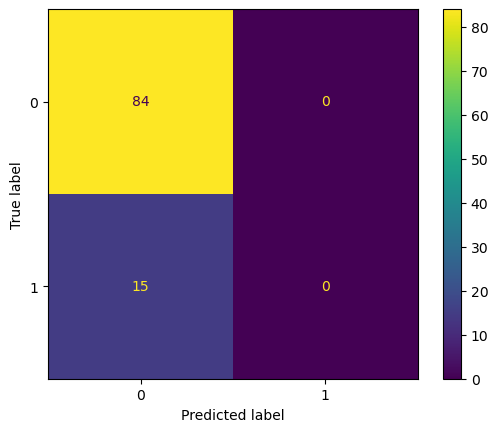

In [80]:
print(classification_report(y_true=y, y_pred=y_pred_dummy, zero_division=0,
      target_names=["Non-Bind", "Bind"]))

cm = confusion_matrix(y, y_pred_dummy, labels=[0, 1])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()
